# Sentiment analysis: *Amazon fine food review*

## Introduction

### Group members

**Minimum 2, Maximum 3**

<span style="color:red">Write below</span>

* Guaranda, Maria
* Khater, Yara
* Castillo, Galo

### Presentation

* The project is based on the Amazon food review from customers dataset
* The original Kaggle competition was to predict whether a review was positive or negative
* In this project, we will add the **neural** level
* You will try to **predict the 3 classes** given by the user according to their **review**
* For this, you will need to use at least 2 **sentence embeddings techniques** (e.g., Word2Vec, BERT)
* The primary metric we will focus on is the **macro-averaged f1-score**
* The dataset contains more than 500K reviews

### Project evaluation

* **4 points**: Exploratory analysis

* **4 points**: Clean and well-documented code (do not forget to **cite** code you reuse, or it will be considered plagiarism)

* **4 points**: Modeling and feature extractions

* **4 points**: Evaluation of the performance of the model

* **4 points**: Quality of the oral presentation

### Download the data

https://www.kaggle.com/snap/amazon-fine-food-reviews/download

(254MB)

In [1]:
import re
from pathlib import Path

import gensim
import gensim.downloader as gensim_api
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import wordcloud
from sklearn import (
    decomposition,
    ensemble,
    feature_extraction,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
)
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

import networkx as nx

import warnings
warnings.filterwarnings('ignore')


In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/galo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
plt.rcParams['figure.dpi'] = 90
plt.rcParams['figure.figsize'] = (11, 7)

sns.set_style("darkgrid")
sns.set_context("notebook")

tqdm.pandas()

%config InlineBackend.figure_format="retina"  # For high DPI display

In [4]:
DATA = Path("archive")

assert DATA.is_dir()

IMG = Path("img")

assert IMG.is_dir()

## Exploration

### Read Data

In [5]:
df = pd.read_csv(DATA / "Reviews.csv")
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [6]:
dim_ini = df.shape[0]

In [7]:
df.drop_duplicates(['Text', 'Summary'], inplace=True, keep='first')
dim = df.shape[0]
print(f"{dim / dim_ini:.2%}, raw_dim: {dim_ini:,}, dim: {dim:,}")

69.48%, raw_dim: 568,454, dim: 394,970


* Contains some product, user, and review information

* Data used here:

    * Text: Complete product review by the customer
    * Summary: Summary proposed by the customer
    * Score: The product rating provided by the customer

### Distribution of the variable ***Score***

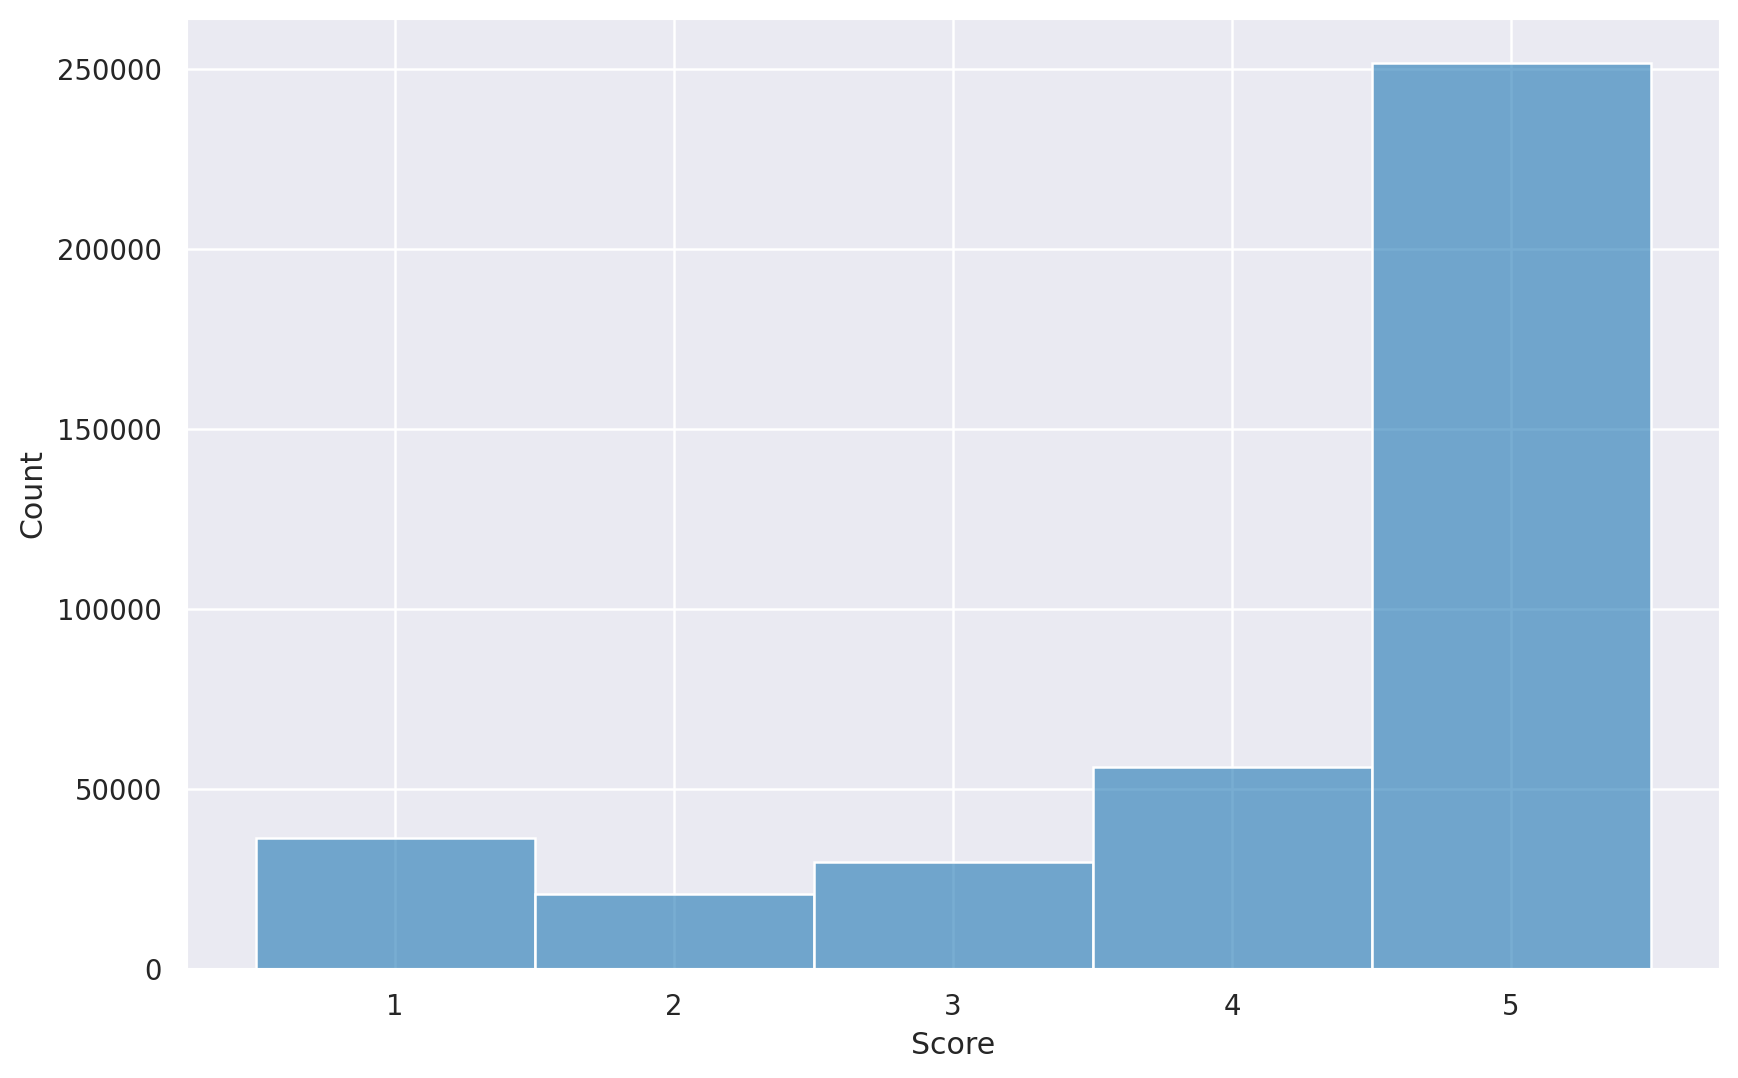

In [8]:
sns.histplot(df, x="Score", alpha=0.6, discrete=True)
plt.show()

* Most of the customer rating is positive 

### Analysis of binary and 3-classes versions

* Convert the 5-classes rating in 3-classes sentiment as a target variable
* Positive reviews will be classified as +1, neutral 0, and negative, -1
* The rating value 3 will be used as threshold

In [9]:
def convert_rating(rating, threshold=3):
    if rating > threshold:
        return 1
    if rating < threshold:
        return -1
    return 0

In [10]:
df["sentiment"] = df.Score.map(convert_rating)

### Words distribution

Let's observe the most frequent words for positive and negative reviews through **word clouds**

In [11]:
# Create stopword list
stopwords = set(wordcloud.STOPWORDS) | set(
    nltk.corpus.stopwords.words("english")
)
stopwords.update(["br", "href"])

In [12]:
def clean_text(text, remove_stopwords=True, lemmatize=True):
    
    lmtzr = WordNetLemmatizer()
    clean_text = str(text)
    
    clean_text = clean_text.lower().strip()
    clean_text = clean_text.replace('<', ' ').replace('>', ' ') # This helps to remove HTML tags and URLs.
    clean_text = re.sub(r"http\S+", "", clean_text)
    clean_text = re.sub('[^a-zA-Z]', ' ', clean_text)
    clean_text = re.sub(' +', ' ', clean_text)
    if remove_stopwords and lemmatize:
        clean_text = ' '.join([lmtzr.lemmatize(word) for word in clean_text.split() if word not in stopwords])
    elif remove_stopwords:
        clean_text = ' '.join([word for word in clean_text.split() if word not in stopwords])
    elif lemmatize:
        clean_text = ' '.join([lmtzr.lemmatize(word) for word in clean_text.split()])    
    return clean_text

In [13]:
df['clean_summary'] = df['Summary'].apply(lambda x: clean_text(x))
df['clean_text'] = df['Text'].apply(lambda x: clean_text(x))

In [14]:
df[['Text', 'clean_text', 'sentiment']].head()

Text  \
0  I have bought several of the Vitality canned d...   
1  Product arrived labeled as Jumbo Salted Peanut...   
2  This is a confection that has been around a fe...   
3  If you are looking for the secret ingredient i...   
4  Great taffy at a great price.  There was a wid...   

                                          clean_text  sentiment  
0  bought several vitality canned dog food produc...          1  
1  product arrived labeled jumbo salted peanut pe...         -1  
2  confection around century light pillowy citrus...          1  
3  looking secret ingredient robitussin believe f...         -1  
4  great taffy great price wide assortment yummy ...          1

In [15]:
positive_df = df[df.sentiment == 1]
negative_df = df[df.sentiment == -1]

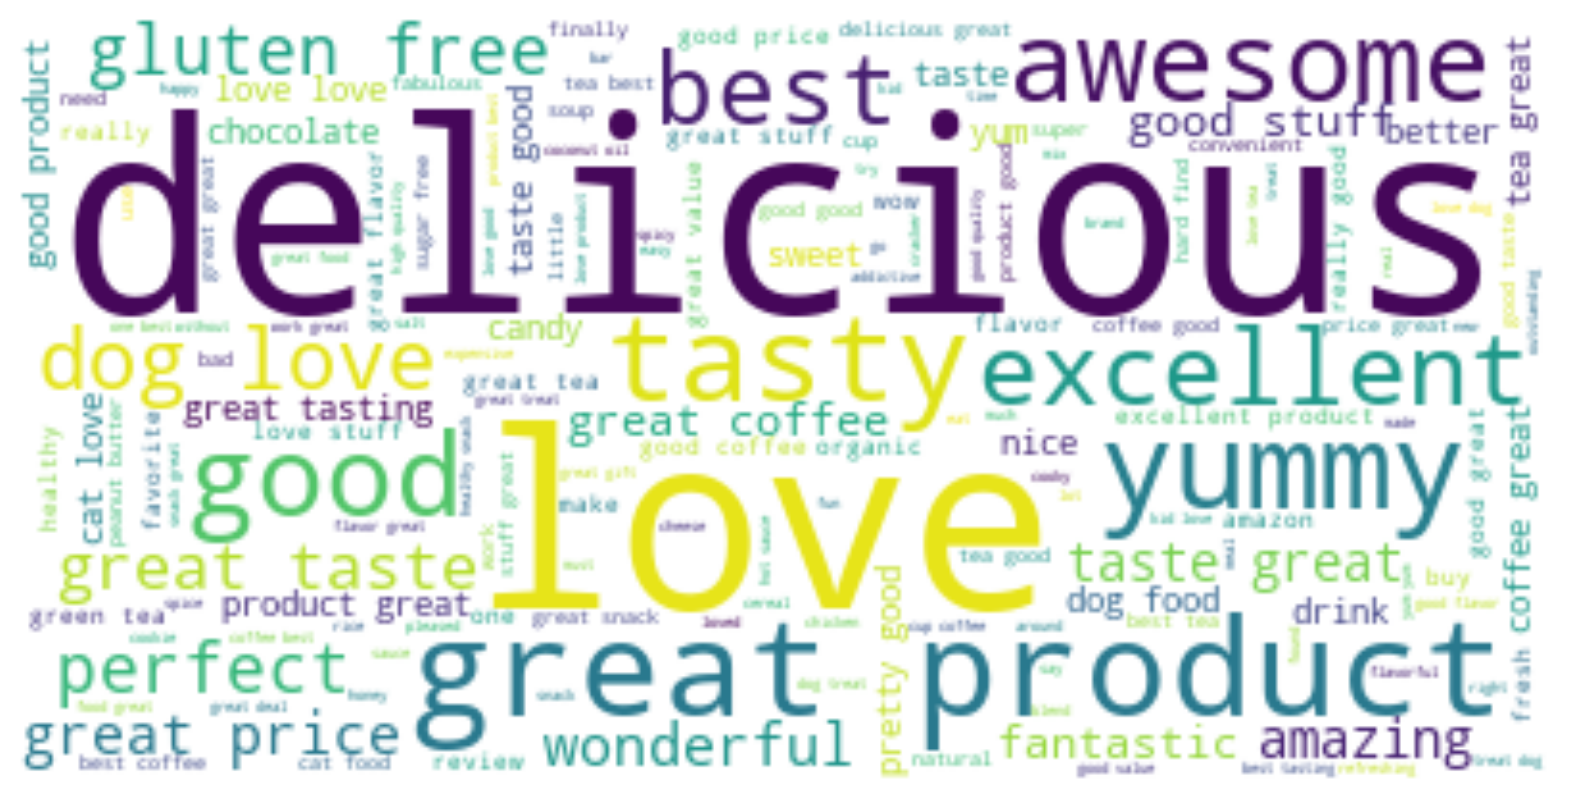

In [16]:
pos_wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
).generate(" ".join(positive_df.clean_summary.dropna()))

plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(IMG / "pos_wordcloud.png")
plt.show()

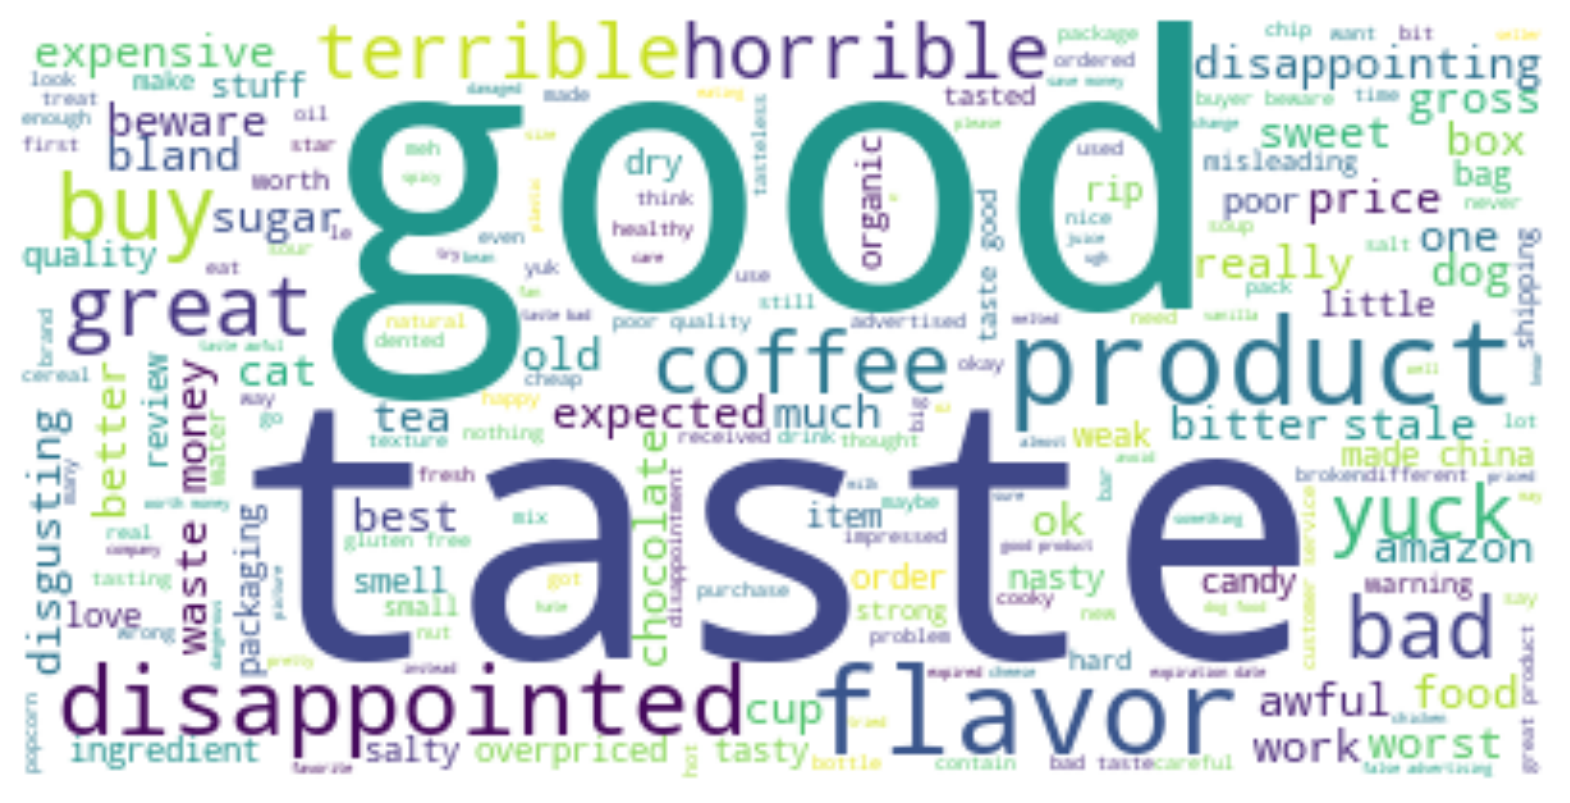

In [17]:
neg_wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
).generate(" ".join(negative_df.clean_summary.dropna()))

plt.imshow(neg_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(IMG / "neg_wordcloud.png")
plt.show()

* Positive sentiment words, e.g., *love, best, delicious*

* Negative sentiment words, e.g., *disappointed, bad, yuck*

* The word ***good*** appears in the negative sentiment word cloud, despite being a positive word 

    * Probably because it was used in a negative context: ***not good*** 

In [18]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Text(0, 0.5, 'Bigrams')

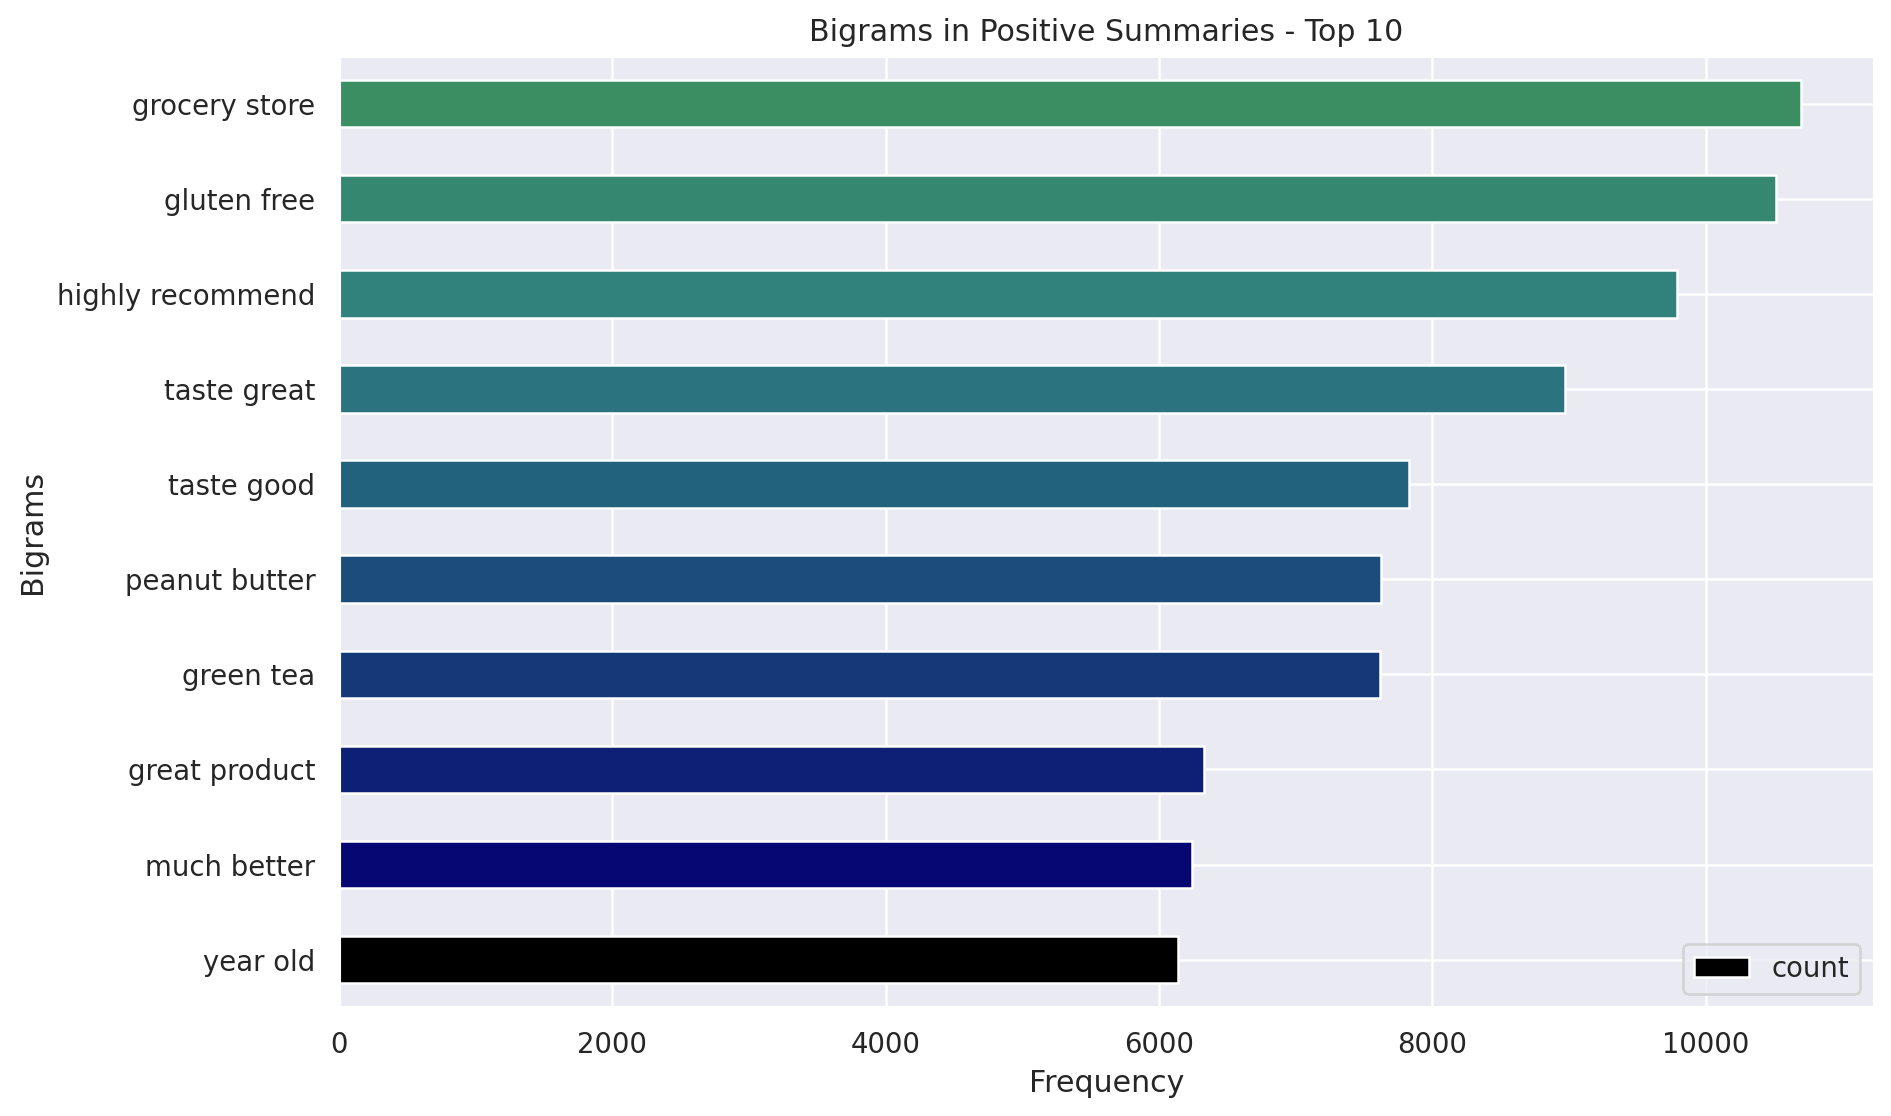

In [19]:
common_words = get_top_n_bigram(positive_df['clean_text'], 10)
df_tmp = pd.DataFrame(common_words, columns = ['bigrams' , 'count'])
color = plt.cm.gist_earth(np.linspace(0, 1, 25))
df_tmp.sort_values('count', ascending=True).plot(x='bigrams', y='count', kind='barh', color=color)
plt.title("Bigrams in Positive Reviews - Top 10")
plt.xlabel('Frequency')
plt.ylabel('Bigrams')

Text(0, 0.5, 'Bigrams')

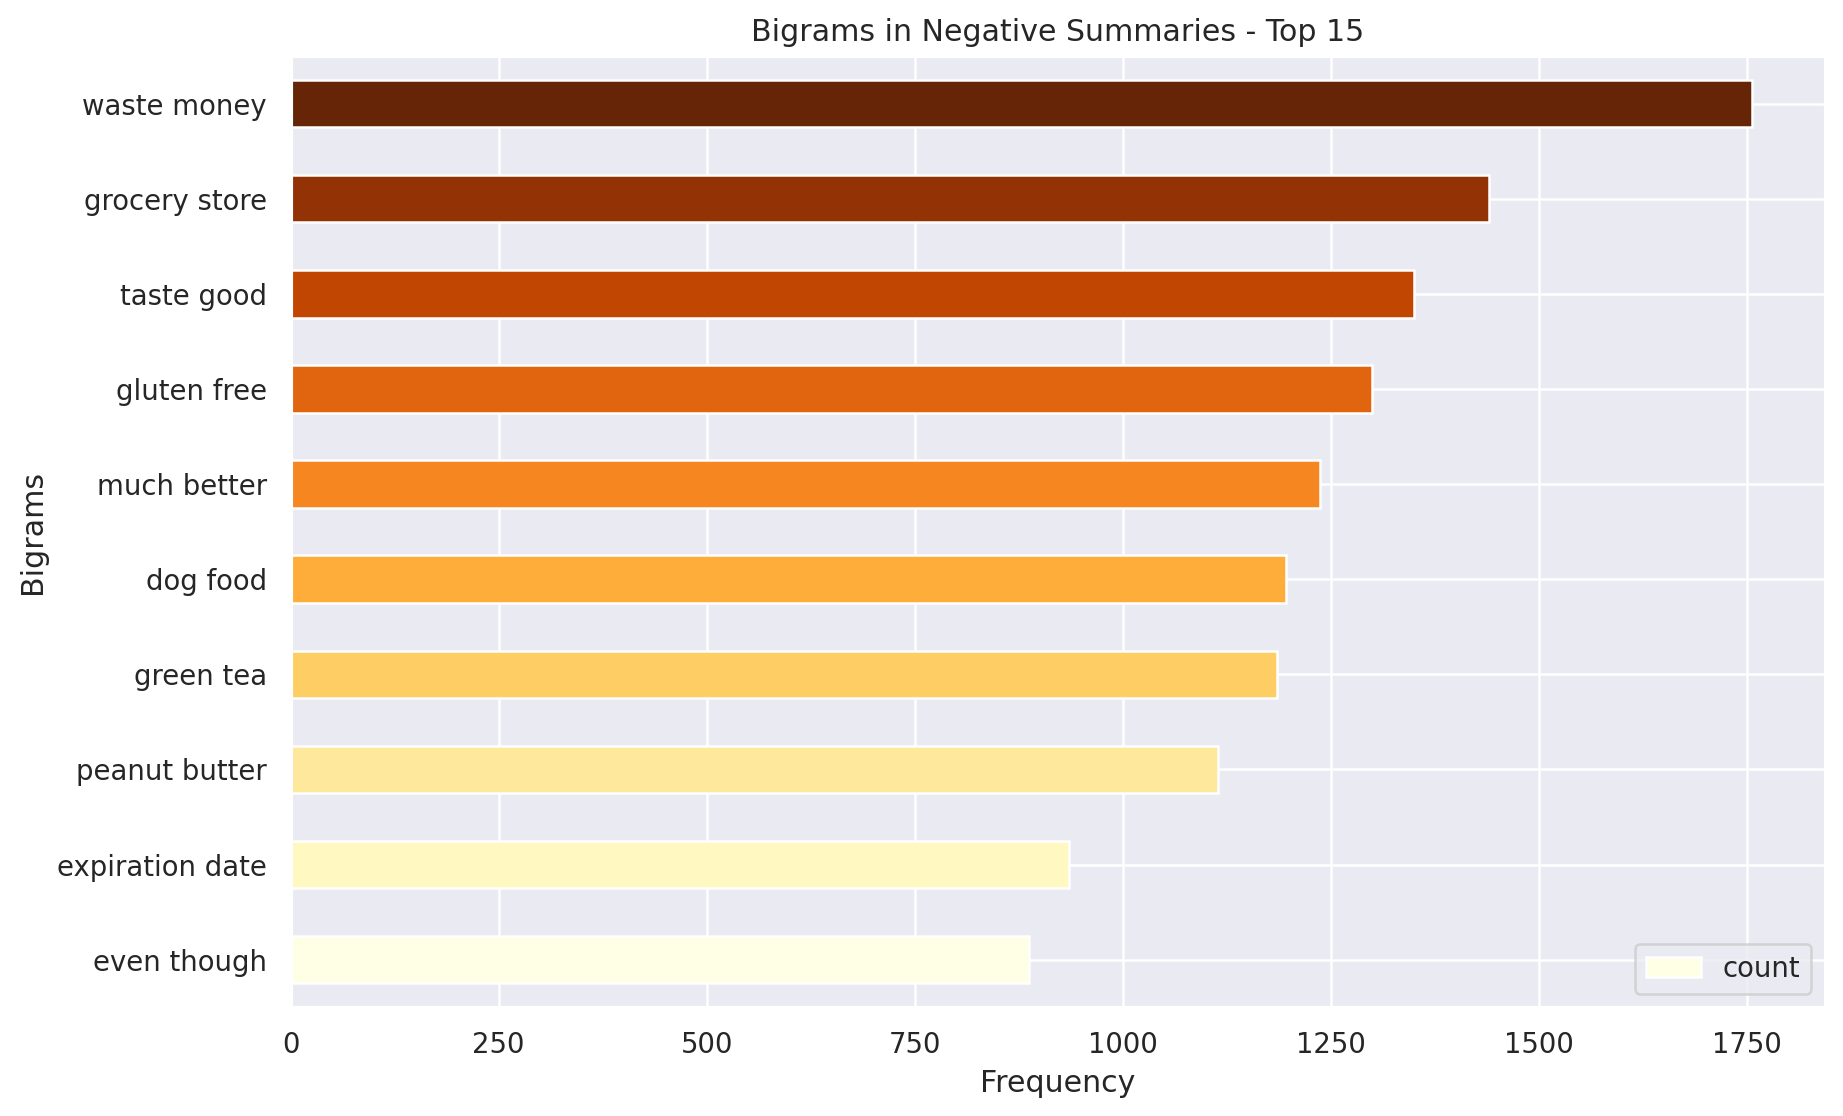

In [20]:
common_words = get_top_n_bigram(negative_df['clean_text'], 10)
df_tmp = pd.DataFrame(common_words, columns = ['bigrams' , 'count'])
color = plt.cm.YlOrBr(np.linspace(0, 1, 10))
df_tmp.sort_values('count', ascending=True).plot(x='bigrams', y='count', kind='barh', color=color)
plt.title("Bigrams in Negative Reviews - Top 10")
plt.xlabel('Frequency')
plt.ylabel('Bigrams')

Why "taste good" is part of the most frequent negative bigrams? Unreached expectations or negations.

**Example 1:**
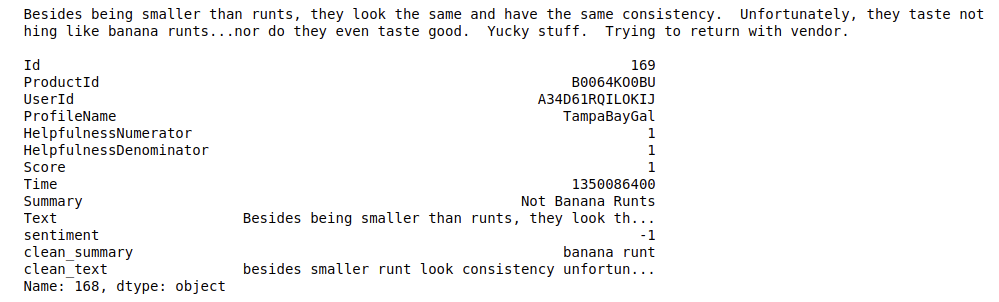

**Example 2:**
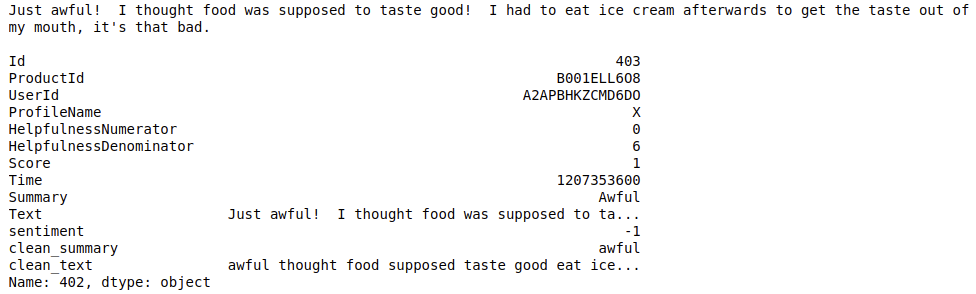

Also, our stopwords set contains words such as *isn't*, so expresions like "the taste *isn't* good" are omitted.

In [119]:
common_words_pos = get_top_n_bigram(positive_df['clean_text'], 50)
common_words_neg = get_top_n_bigram(negative_df['clean_text'], 50)

bigrams_df = pd.DataFrame(common_words_pos + common_words_neg, columns = ['bigrams' , 'count'])
bigrams_df.head(10)

bigrams  count
0     grocery store  10695
1       gluten free  10513
2  highly recommend   9791
3       taste great   8970
4        taste good   7829
5     peanut butter   7625
6         green tea   7615
7     great product   6328
8       much better   6241
9          year old   6138

In [120]:
bigrams_df = pd.DataFrame(common_words_pos + common_words_neg, columns = ['bigrams' , 'count'])
bigrams_df = bigrams_df.groupby(['bigrams'], as_index=False)['count'].agg('sum')

In [121]:
# Create network plot 
G = nx.Graph()
for index, row in bigrams_df.iterrows():
    # Create connections between nodes
    n1 = row['bigrams'].split()[0]
    n2 = row['bigrams'].split()[1]
    w = row['count']
    G.add_edge(n1, n2, weight=(w * 10))

In [122]:
words_negative = set([t[0].split()[0] for t in common_words_neg] + [t[0].split()[1] for t in common_words_neg])
words_positive = set([t[0].split()[0] for t in common_words_pos] + [t[0].split()[1] for t in common_words_pos])
words_common = words_positive & words_negative
nodes_colors = ['limegreen' if node in words_positive - words_common else 'red' if node in words_negative - words_common else 'gray' for node in G.nodes]

We build a co-occurence of terms contained in most frequent bigrams. Each **node** corresponds to a **term** that appears in the the top 50 most frequent bigrams of negative reviews or positive reviews (or maybe both). An edge between two nodes (terms) appears when the two connected nodes form at least one bigram.

- Red colored nodes corresponds to terms that only appear on most frequent bigrams on negative reviews.
- Green colored nodes corresponds to terms that only appear on most frequent bigrams on positive reviews.
- Gray colored nodes corresponds to terms that appear on most frequent bigrams on positive **and** negative reviews.

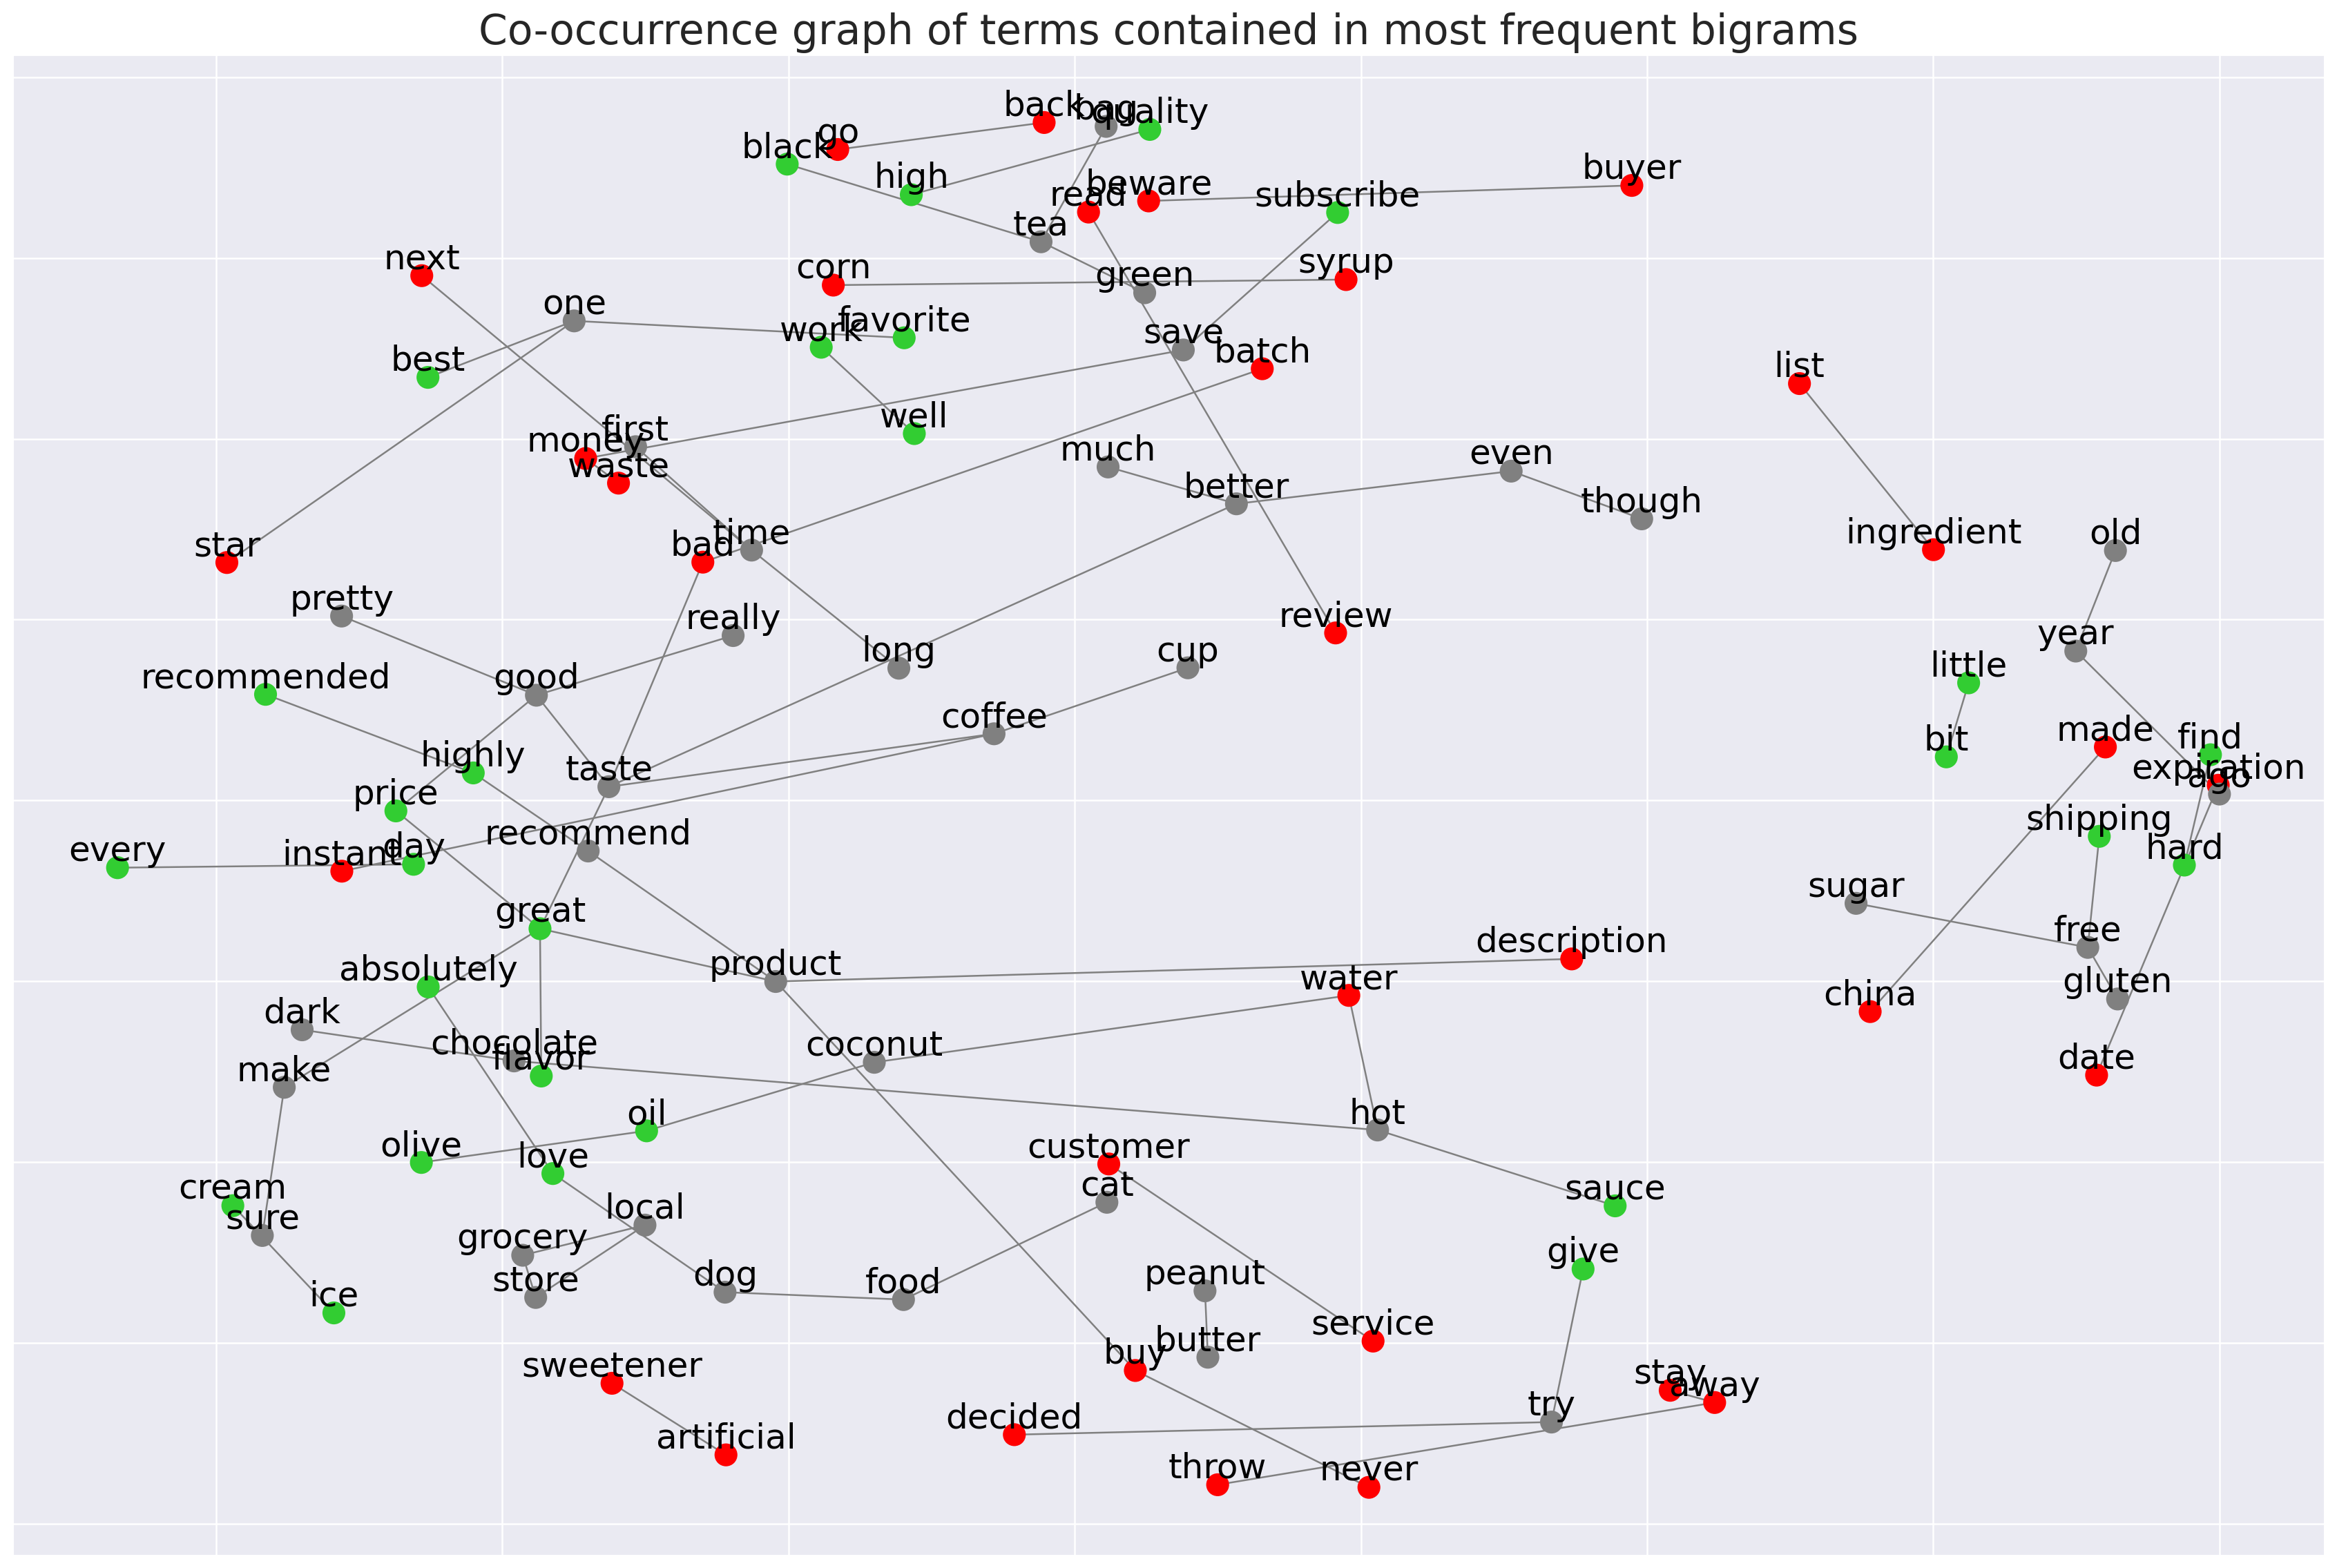

In [129]:
fig, ax = plt.subplots(figsize=(24, 16))

pos = nx.spring_layout(G, k=17, seed=1, iterations=100)
nx.draw_networkx(G, pos,
                 font_size=20,
                 width=1,
                 edge_color='grey',
#                 node_color='darkblue',
                 node_color=nodes_colors,
                 node_size=150,
                 with_labels = True,
                 verticalalignment='bottom',
                 ax=ax)    
plt.title('Co-occurrence graph of terms contained in most frequent bigrams', fontsize=24)
plt.show()

In [131]:
df["sentiment_text"] = (
    df.sentiment.replace({-1: "negative", 0: "neutral", 1: "positive"})
    .astype("category")  # To set the x-axis order in sns.histplot
    .cat.reorder_categories(["positive", "neutral", "negative"])
)

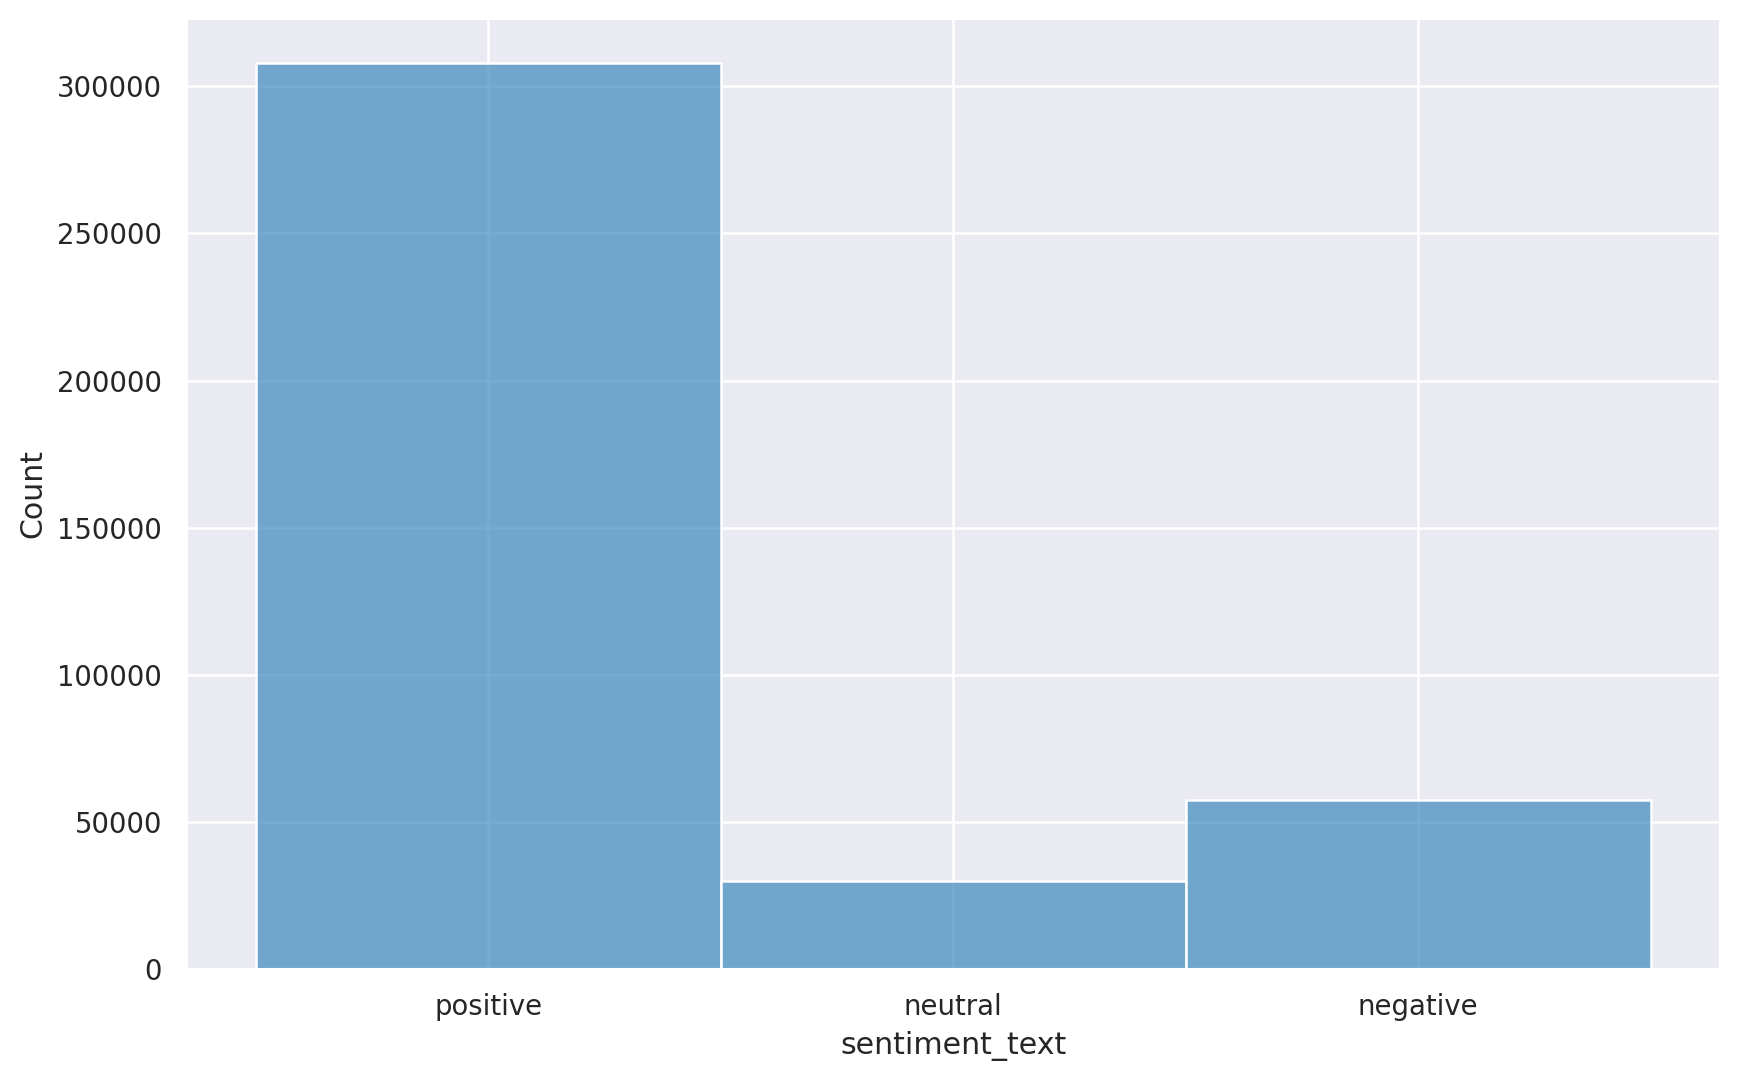

In [132]:
sns.histplot(
    df,
    x="sentiment_text",
    alpha=0.6,
    discrete=True,
)
plt.show()

In [133]:
100*df['sentiment_text'].value_counts(normalize=True)

positive    77.926678
negative    14.519077
neutral      7.554245
Name: sentiment_text, dtype: float64

### Other Exploratory Data Analysis

In [134]:
df['Summary'] = df['Summary'].astype(str)
df['Text'] = df['Text'].astype(str)

df['summary_tokens_num'] = df['clean_summary'].apply(lambda x: len(x.split()))
df['text_tokens_num'] = df['clean_text'].apply(lambda x: len(x.split()))

df['summary_len'] = df['clean_summary'].apply(lambda x: len(x))
df['text_len'] = df['clean_text'].apply(lambda x: len(x))

Text(0.5, 1.0, 'Distribution of the number of tokens per sentiment category')

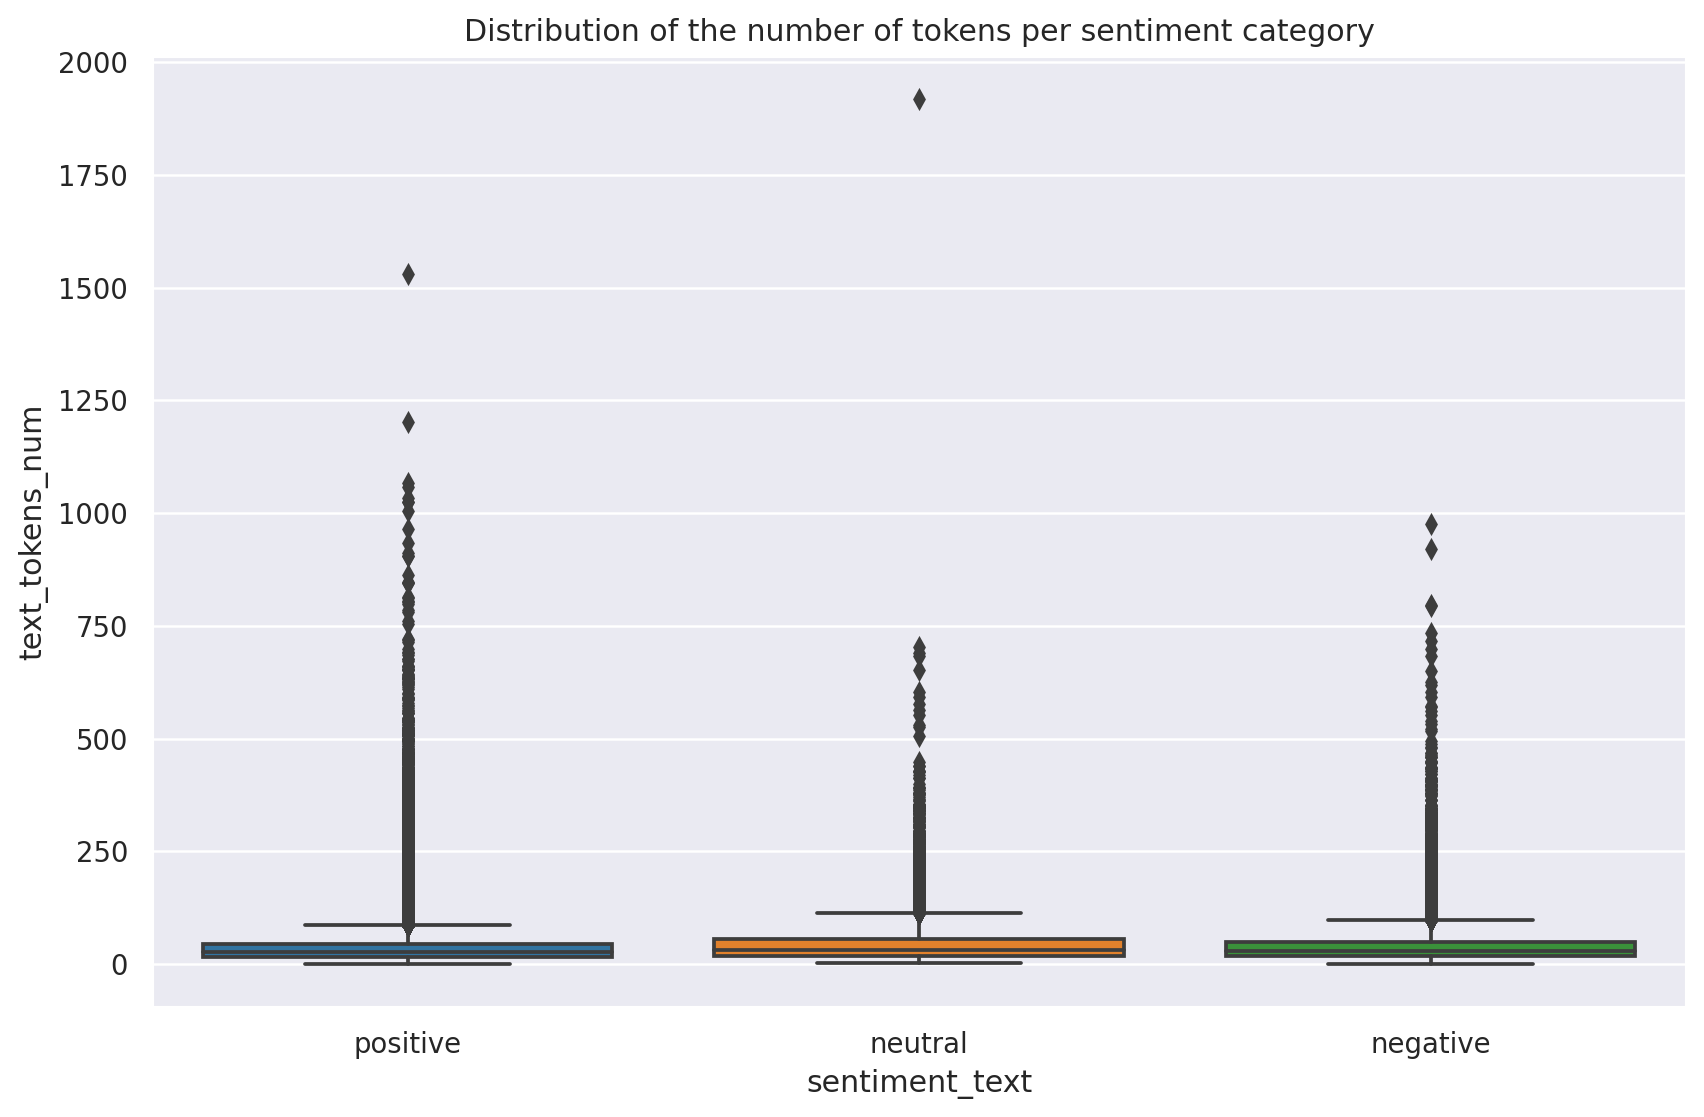

In [135]:
sns.boxplot(x="sentiment_text", y="text_tokens_num", data=df)
plt.title('Distribution of the number of tokens per sentiment category')

Text(0.5, 1.0, 'Distribution of the number of tokens per sentiment category without outliers')

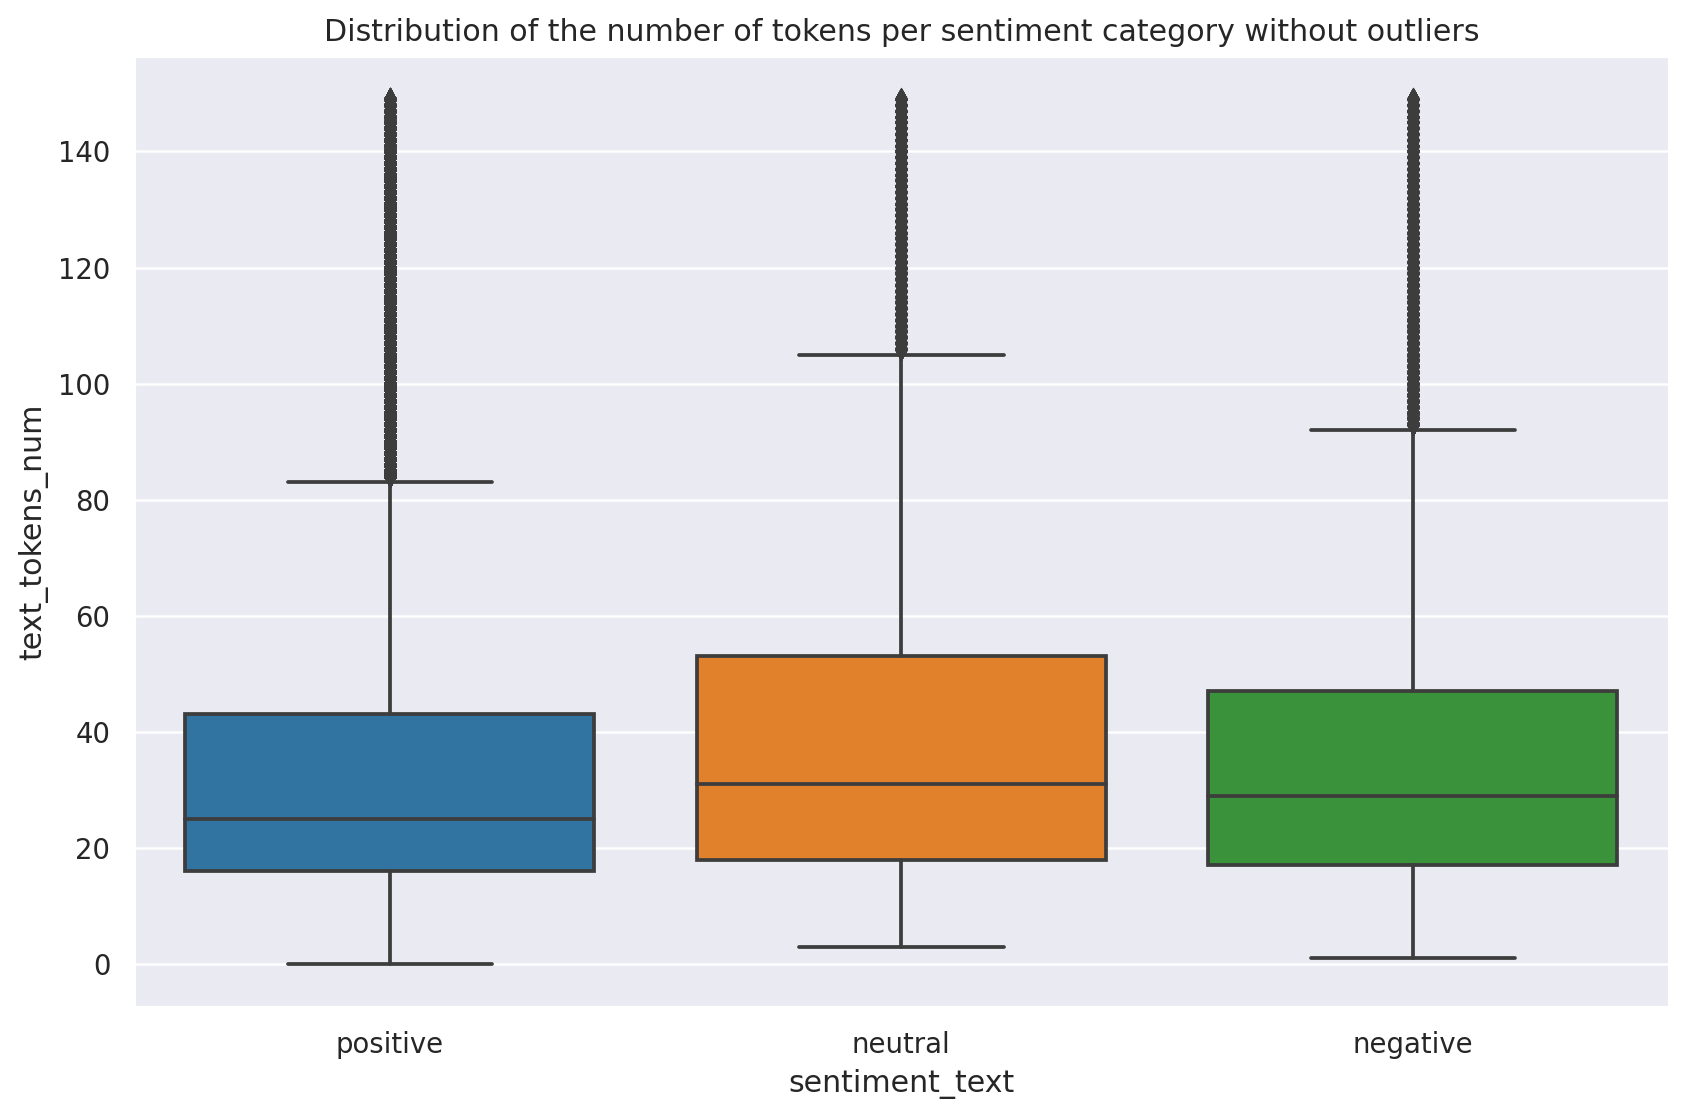

In [136]:
sns.boxplot(x="sentiment_text", y="text_tokens_num", data=df.loc[df['text_tokens_num'] < 150])
plt.title('Distribution of the number of tokens per sentiment category without outliers')

In [137]:
positive_df = df[df.sentiment == 1]
neutral_df = df[df.sentiment == 0]
negative_df = df[df.sentiment == -1]

In [138]:
negative_tokens = ' '.join(negative_df.clean_text)
negative_tokens = negative_tokens.split()

neutral_tokens = ' '.join(neutral_df.clean_text)
neutral_tokens = neutral_tokens.split()

positive_tokens = ' '.join(positive_df.clean_text)
positive_tokens = positive_tokens.split()

In [139]:
import collections
tokTypes = {}
tokens_by_sent = {'neg': negative_tokens, 'neu': neutral_tokens, 'pos': positive_tokens}
for cat, t in tokens_by_sent.items():
    print(cat)
    typenrs = []
    for i in range(0, max([len(negative_tokens), len(neutral_tokens), len(positive_tokens)]), 100000):
        typenrs += [len(collections.Counter(t[:i]))/(i+1)]
    tokTypes[cat]=typenrs

neg
neu
pos


Text(0, 0.5, 'Ratio of token types by total tokens')

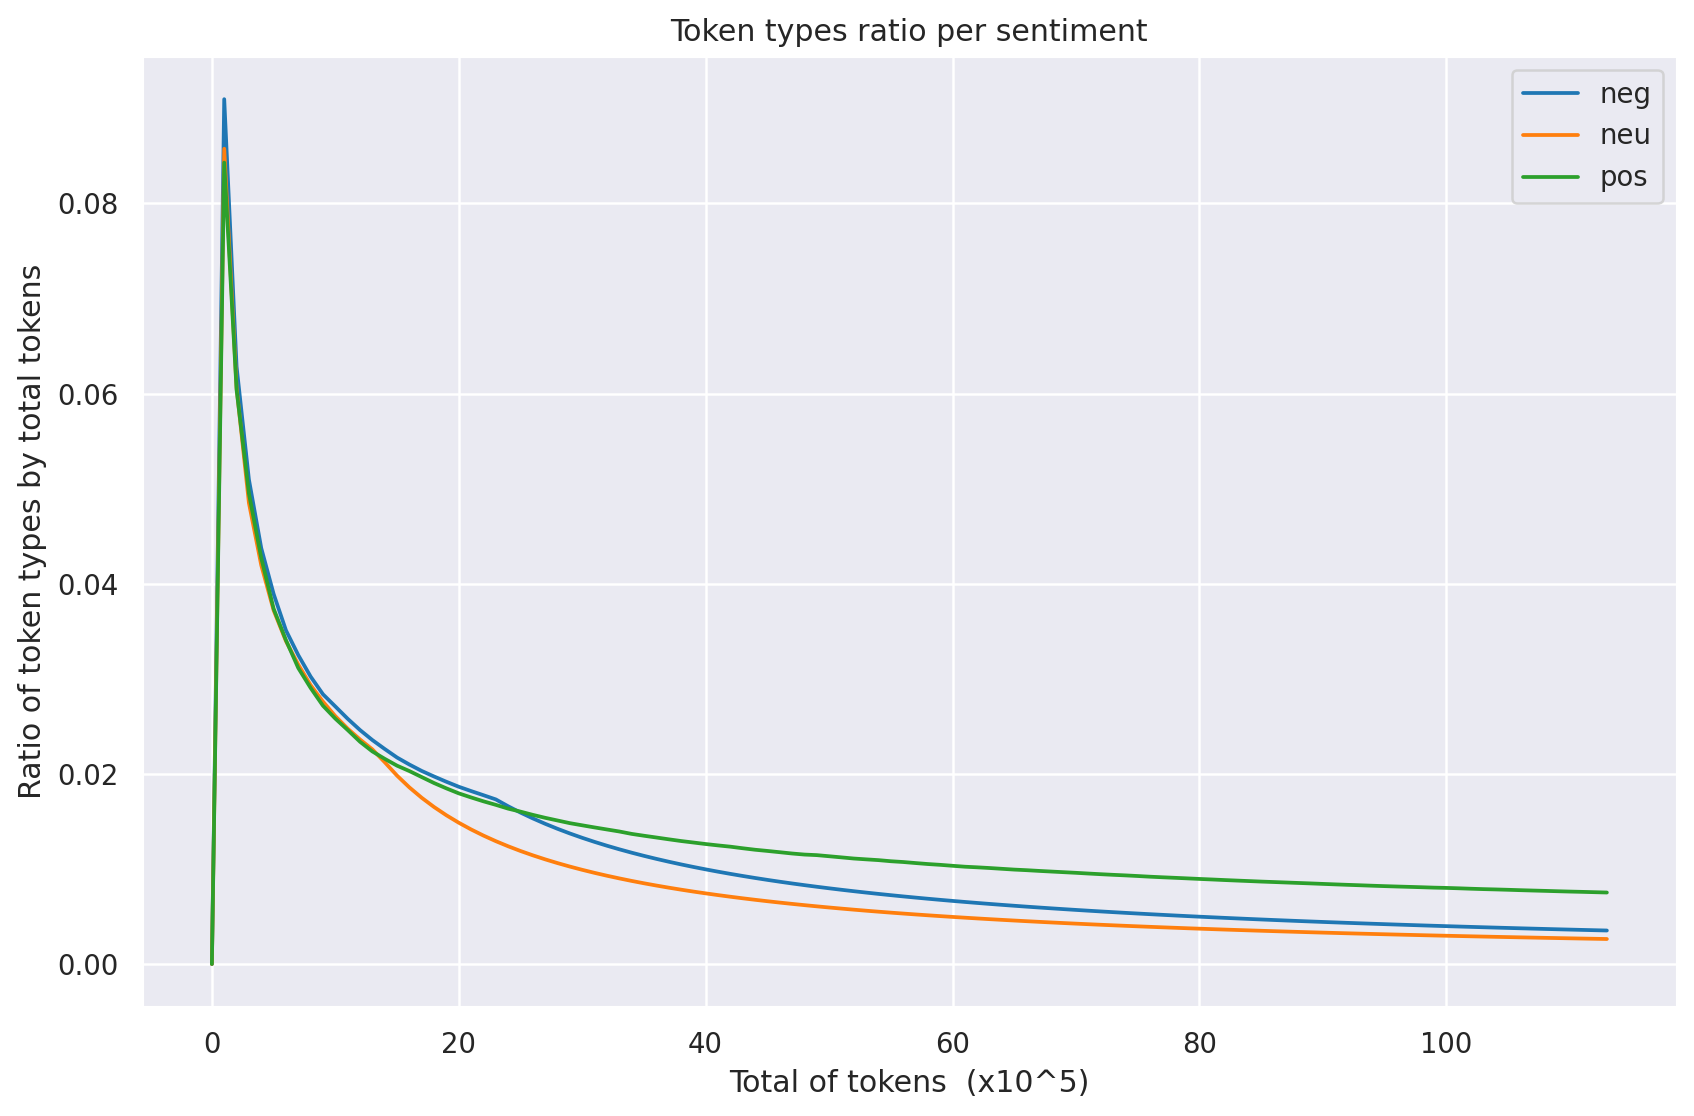

In [140]:
pd.DataFrame.from_dict(tokTypes).plot()
plt.title('Token types ratio per sentiment')
plt.xlabel('Total of tokens  (x10^5)')
plt.ylabel('Ratio of token types by total tokens')

<AxesSubplot:>

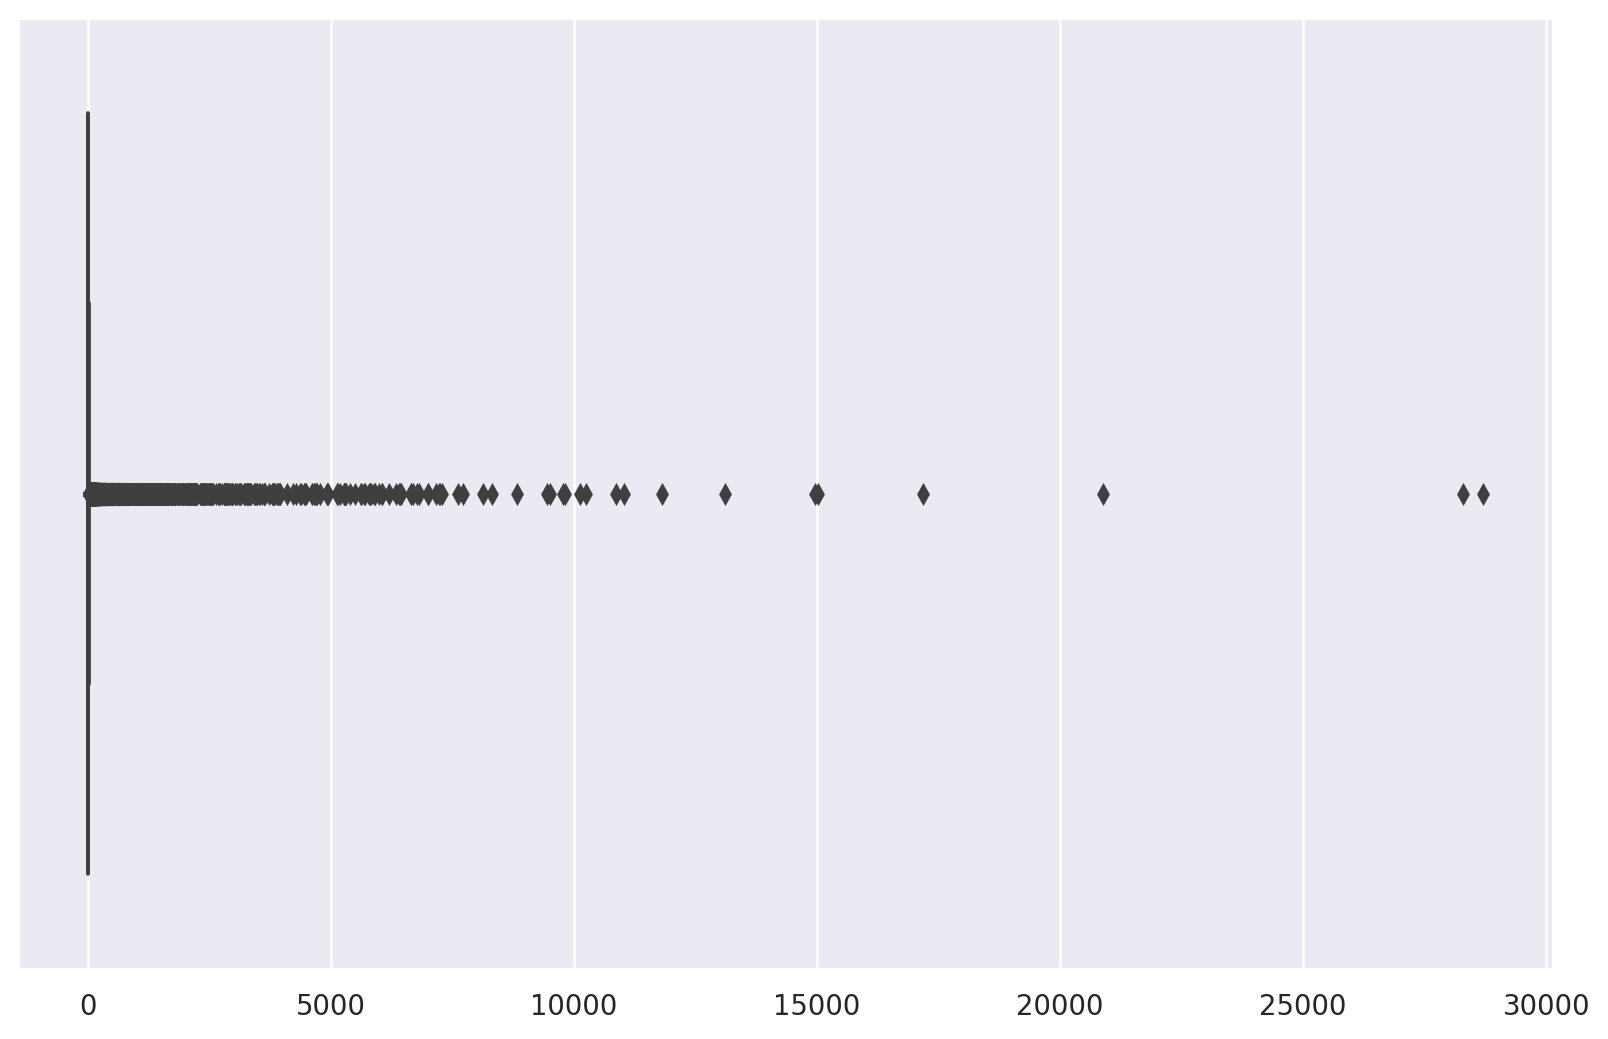

In [141]:
sns.boxplot(list(dict(collections.Counter(negative_tokens)).values()))

#### ScatterText 

Now we will develop an ScatterText, which will let us gain more understanding on which terms from our corpus are more related to negative or positive.

In [161]:
import scattertext as st
corpus = st.CorpusFromPandas(df.sample(n=10000, replace=False, random_state=0),
                             category_col='sentiment_text',
                             text_col='clean_summary').build()

In [162]:
html = st.produce_scattertext_explorer(corpus,
        category='positive',
        category_name='Positive',            
        not_categories=['negative'],
        not_category_name='Negative',
        neutral_categories=['neutral'],
        neutral_category_name='Neutral',
        show_neutral=True,
        show_diagonal=True,        
        width_in_pixels=1000)

In [163]:
file_name = 'reviews_scattertext_summary_001.html'
open(file_name, 'wb').write(html.encode('utf-8'))

770089

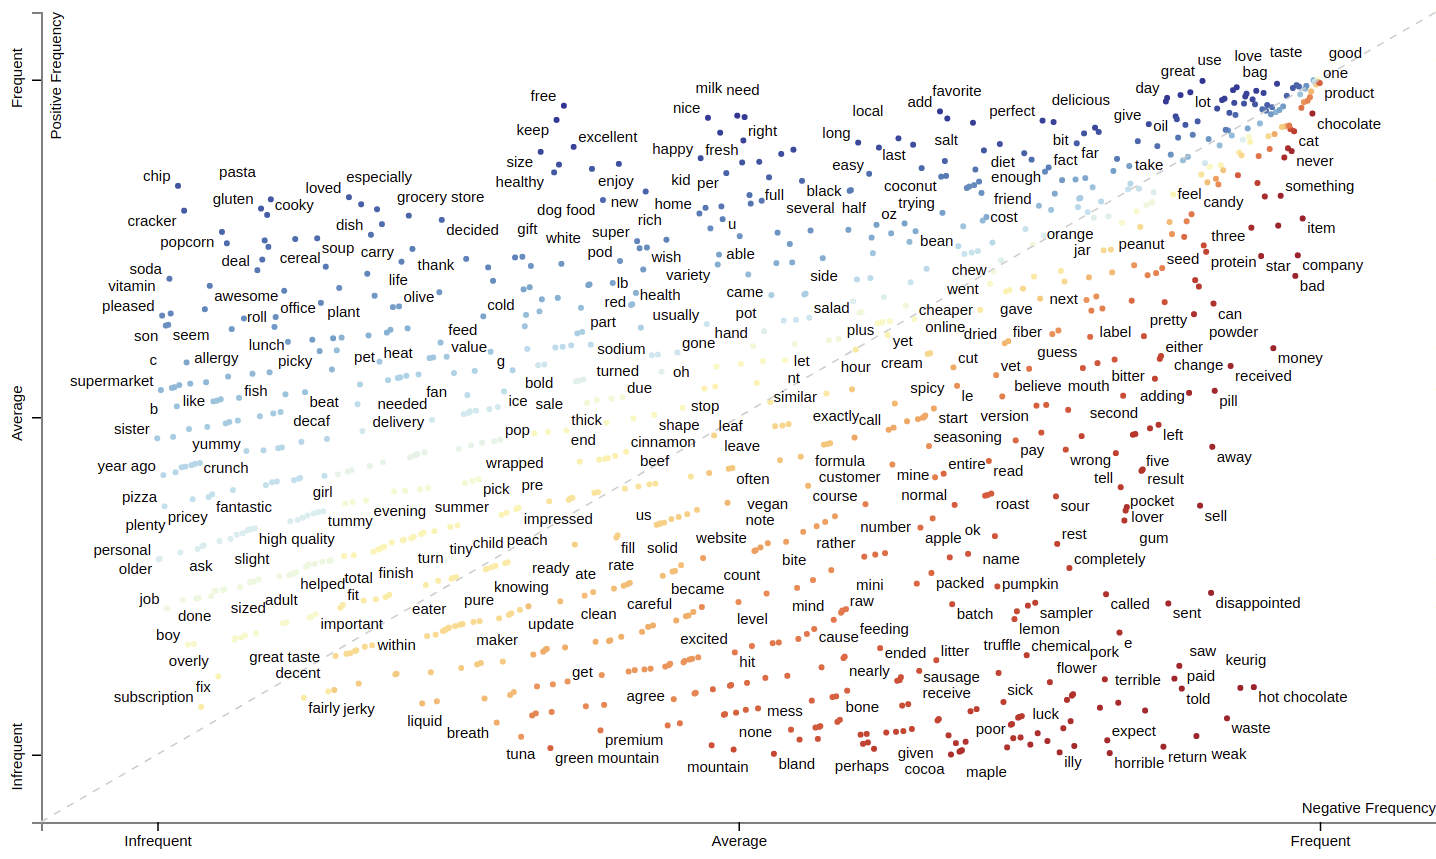

https://dainstudios.com/insights/text-visualization-of-stand-up-comedy-with-scattertext/

https://github.com/JasonKessler/scattertext

## Create the train and test sets

In [40]:
train_df, test_df = model_selection.train_test_split(
    df, test_size=0.2, random_state=1
)

In [155]:
# List of model available on Gensim
for k in gensim_api.info()["models"]:
    print(k)

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [156]:
#WV = gensim_api.load("glove-wiki-gigaword-100")
WV = gensim_api.load("glove-twitter-100")

In [157]:
train_df.head()

Id   ProductId          UserId  \
398564  398565  B0025UC2DQ  A3PD37SHJLC75F   
319077  319078  B002ZOKNGU  A2XRK888UMWOX9   
14526    14527  B000LKU3GU  A37Z843SR49K8P   
111931  111932  B000QDNIKU  A1B05MH4LU6QYK   
99237    99238  B0009ETA76  A3KDHG8LAGNA1Q   

                                  ProfileName  HelpfulnessNumerator  \
398564  Holly-Go-Lightly "movie buff extreme"                     1   
319077                            H. G. Brown                     0   
14526                               Ana Logue                     0   
111931                                Excited                     1   
99237                                     Amy                     0   

        HelpfulnessDenominator  Score        Time                     Summary  \
398564                       2      5  1268265600           Love that Truvia!   
319077                       0      5  1344643200   Review of Luzianne Coffee   
14526                        0      1  1234742400   Too salty, strange flavor   
111931                       1      4  1311638400        Better than expected   
99237                        0      3  1329350400  Not sure if this worked...   

                                                     Text  sentiment  \
398564  Truvia gives very close to the 'sweetness' tha...          1   
319077  Luzianne Coffee is the best Coffee I have ever...          1   
14526   I found this flavor of Primal Strips Spicy & (...         -1   
111931  Wanted something that is pretty much hassle fr...          1   
99237   I started taking this when my baby was about 1...          0   

                 clean_summary  \
398564             love truvia   
319077  review luzianne coffee   
14526     salty strange flavor   
111931         better expected   
99237              sure worked   

                                               clean_text sentiment_text  \
398564  truvia give close sweetness equal understand w...       positive   
319077  luzianne coffee best coffee tasted year old tr...       positive   
14526   found flavor primal strip spicy hot mushroom o...       negative   
111931  wanted something pretty much hassle free got p...       positive   
99237   started taking baby month trying make one year...        neutral   

        summary_tokens_num  text_tokens_num  summary_len  text_len  
398564                   2               13           11        90  
319077                   3               23           22       145  
14526                    3              109           20       736  
111931                   2               73           15       453  
99237                    2               34           11       235

In [158]:
cln_df = train_df[["Text", "sentiment"]].copy()
cln_df.dropna(subset=["Text"], inplace=True)

## LSTM model on GloVe representation

In [543]:
from tensorflow.keras.layers import LSTM, Activation, Dropout, Dense, Input, Bidirectional
from tensorflow.keras.layers import Embedding, SpatialDropout1D
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import regularizers

In [544]:
X_train, X_val,Y_train, Y_val = model_selection.train_test_split([clean_text(t, True, False) for t in cln_df.Text],
                                                   cln_df.sentiment, test_size=0.3, random_state = 1)

In [545]:
from imblearn.under_sampling import RandomUnderSampler 

In [546]:
Y_train.value_counts()

 1    172542
-1     31976
 0     16665
Name: sentiment, dtype: int64

In [547]:
100*Y_train.value_counts(normalize=True)

 1    78.008708
-1    14.456807
 0     7.534485
Name: sentiment, dtype: float64

In [548]:
print('Size of Train*:', int(len(train_df)/1000), 'K')
print('Size of Train:', int(len(X_train)/1000), 'K')
print('Size of Validation:', int(len(X_val)/1000), 'K')

Size of Train*: 315 K
Size of Train: 221 K
Size of Validation: 94 K


In [549]:
#X_train = X_train[:32000]
#Y_train = Y_train[:32000]

#X_val = X_val[:8000]
#Y_val = Y_val[:8000]

In [550]:
NUM_WORDS = 3000

tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index

In [551]:
WV.vector_size

100

In [552]:
word_to_vec_map = WV
maxLen = 103

In [553]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

#emb_matrix = np.zeros((vocab_len, embed_vector_len))
emb_matrix = np.zeros((NUM_WORDS, embed_vector_len))
for word, index in words_to_index.items():
    if index > NUM_WORDS:
        break
    try:
        embedding_vector = word_to_vec_map[word]
    except:
        continue
    emb_matrix[index-1, :] = embedding_vector

#embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)    
embedding_layer = Embedding(input_dim=NUM_WORDS, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)    

In [554]:
def create_lstm_v1(X):
    model = Sequential()
#    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(Embedding(5000, 100, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    return model


def create_lstm_v2(X):
    model = Sequential()
    model.add(Embedding(5000, 100, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, activation='relu',return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    return model

def create_lstm_v3(X):
    model = Sequential()
#    model.add(Embedding(NUM_WORDS, 100, input_length=X.shape[1]))
    model.add(embedding_layer)
    model.add(SpatialDropout1D(0.2))
#    model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(3, activation='softmax'))
    return model

def create_lstm_v4(X):
    model = Sequential()
    model.add(embedding_layer)
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))),
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    return model

def create_lstm_v5(X):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, dropout=0.1, recurrent_dropout=0.1)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu')),
    model.add(Dropout(0.15))
    model.add(Dense(3, activation='softmax'))
    return model

In [555]:
X_train_indices = tokenizer.texts_to_sequences(X_train)
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')

X_val_indices = tokenizer.texts_to_sequences(X_val)
X_val_indices = pad_sequences(X_val_indices, maxlen=maxLen, padding='post')

In [556]:
Y_train.value_counts()

 1    172542
-1     31976
 0     16665
Name: sentiment, dtype: int64

In [557]:
rus = RandomUnderSampler(sampling_strategy={-1: 31976, 0: 16665, 1: 31976}, random_state=42)
X_train_indices, Y_train = rus.fit_resample(X_train_indices, Y_train)

In [558]:
from tensorflow.keras.utils import to_categorical
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)

In [559]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(np.argmax(Y_val.to_numpy(), axis=1)),
                                                 np.argmax(Y_val.to_numpy(), axis=1))
class_weights

array([2.29317561, 4.37883407, 0.42816427])

In [560]:
model = create_lstm_v5(X_train_indices)
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 103, 100)          300000    
_________________________________________________________________
dropout_26 (Dropout)         (None, 103, 100)          0         
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 256)               234496    
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 3)               

In [561]:
from tensorflow.keras import backend as K
import tensorflow as tf

def f1_macro(y_true, y_pred):
    # https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [562]:
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[f1_macro])

history = model.fit(X_train_indices, Y_train, batch_size=64, epochs=50,
                    validation_data=(X_val_indices, Y_val),
                    class_weight=class_weight
                   )

Train on 80617 samples, validate on 94793 samples
Epoch 1/50
80617/80617 [==============================] - 233s 3ms/sample - loss: 1.0362 - f1_macro: 0.1665 - val_loss: 0.9013 - val_f1_macro: 0.2853
Epoch 2/50
80617/80617 [==============================] - 229s 3ms/sample - loss: 1.0010 - f1_macro: 0.2890 - val_loss: 0.8554 - val_f1_macro: 0.3174
Epoch 3/50
80617/80617 [==============================] - 228s 3ms/sample - loss: 0.9821 - f1_macro: 0.3185 - val_loss: 0.8354 - val_f1_macro: 0.3386
Epoch 4/50
80617/80617 [==============================] - 230s 3ms/sample - loss: 0.9603 - f1_macro: 0.3466 - val_loss: 0.7539 - val_f1_macro: 0.3758
Epoch 5/50
80617/80617 [==============================] - 274s 3ms/sample - loss: 0.9393 - f1_macro: 0.3682 - val_loss: 0.8051 - val_f1_macro: 0.3804
Epoch 6/50
80617/80617 [==============================] - 250s 3ms/sample - loss: 0.9186 - f1_macro: 0.3872 - val_loss: 0.7293 - val_f1_macro: 0.4177
Epoch 7/50
80617/80617 [==========================

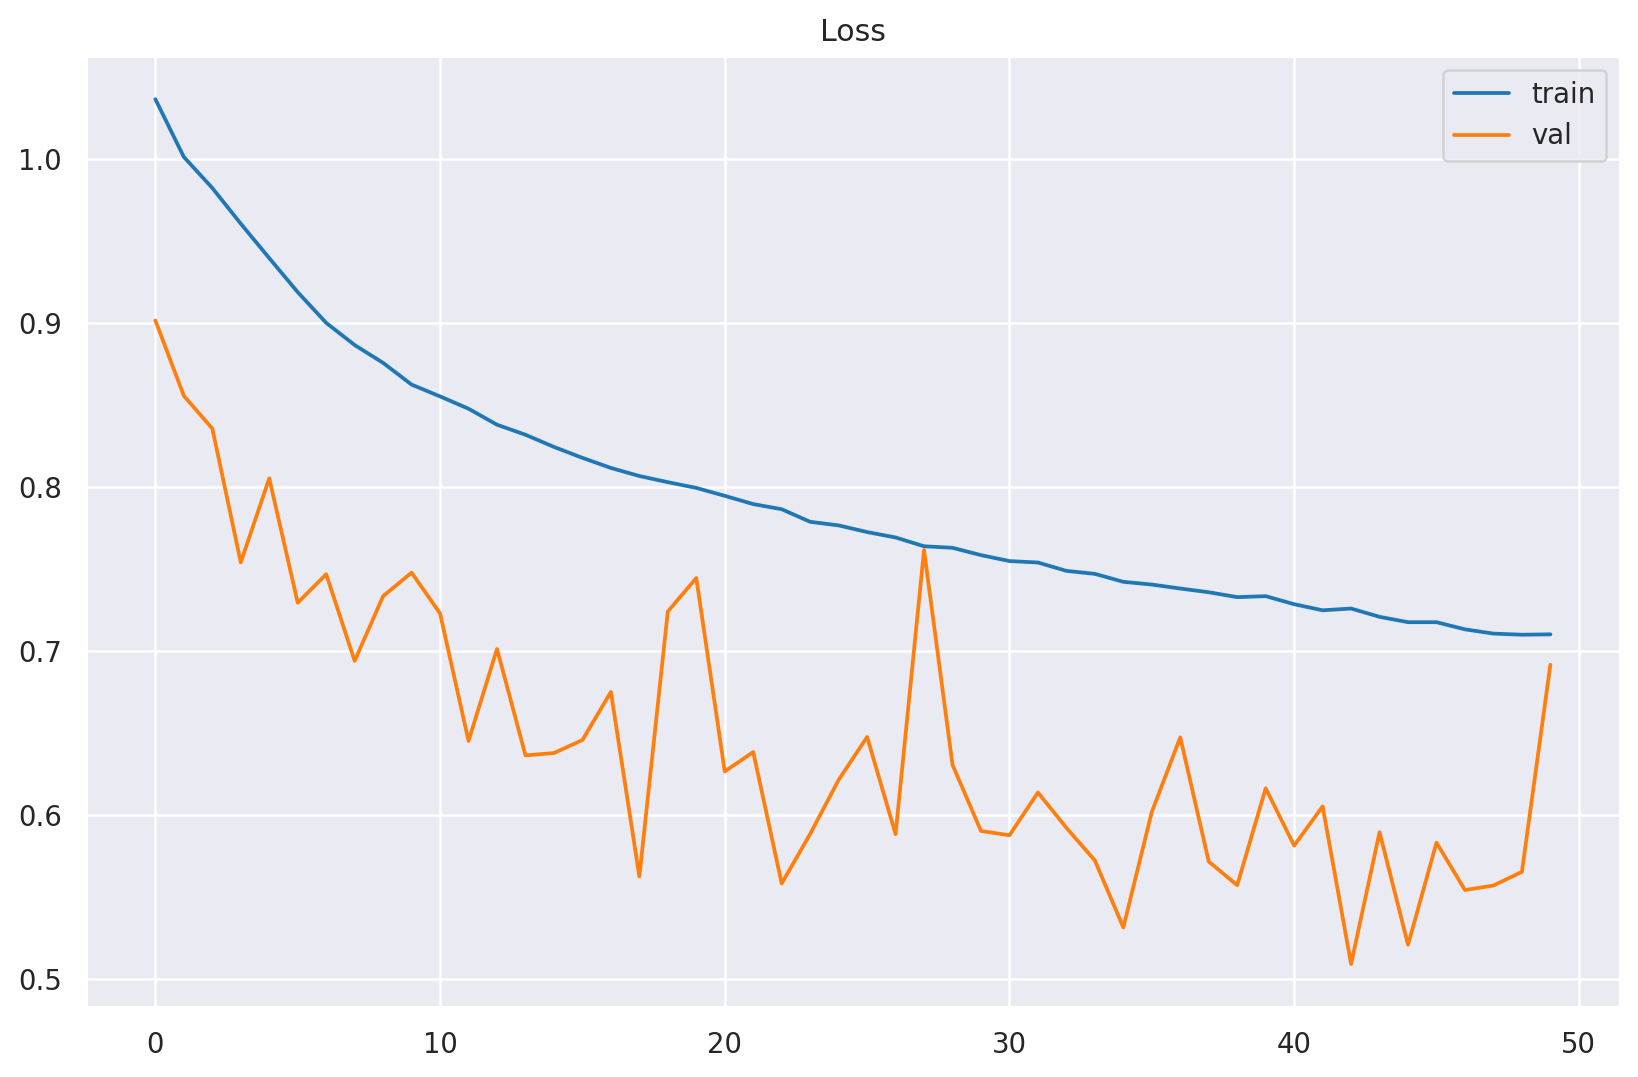

In [563]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

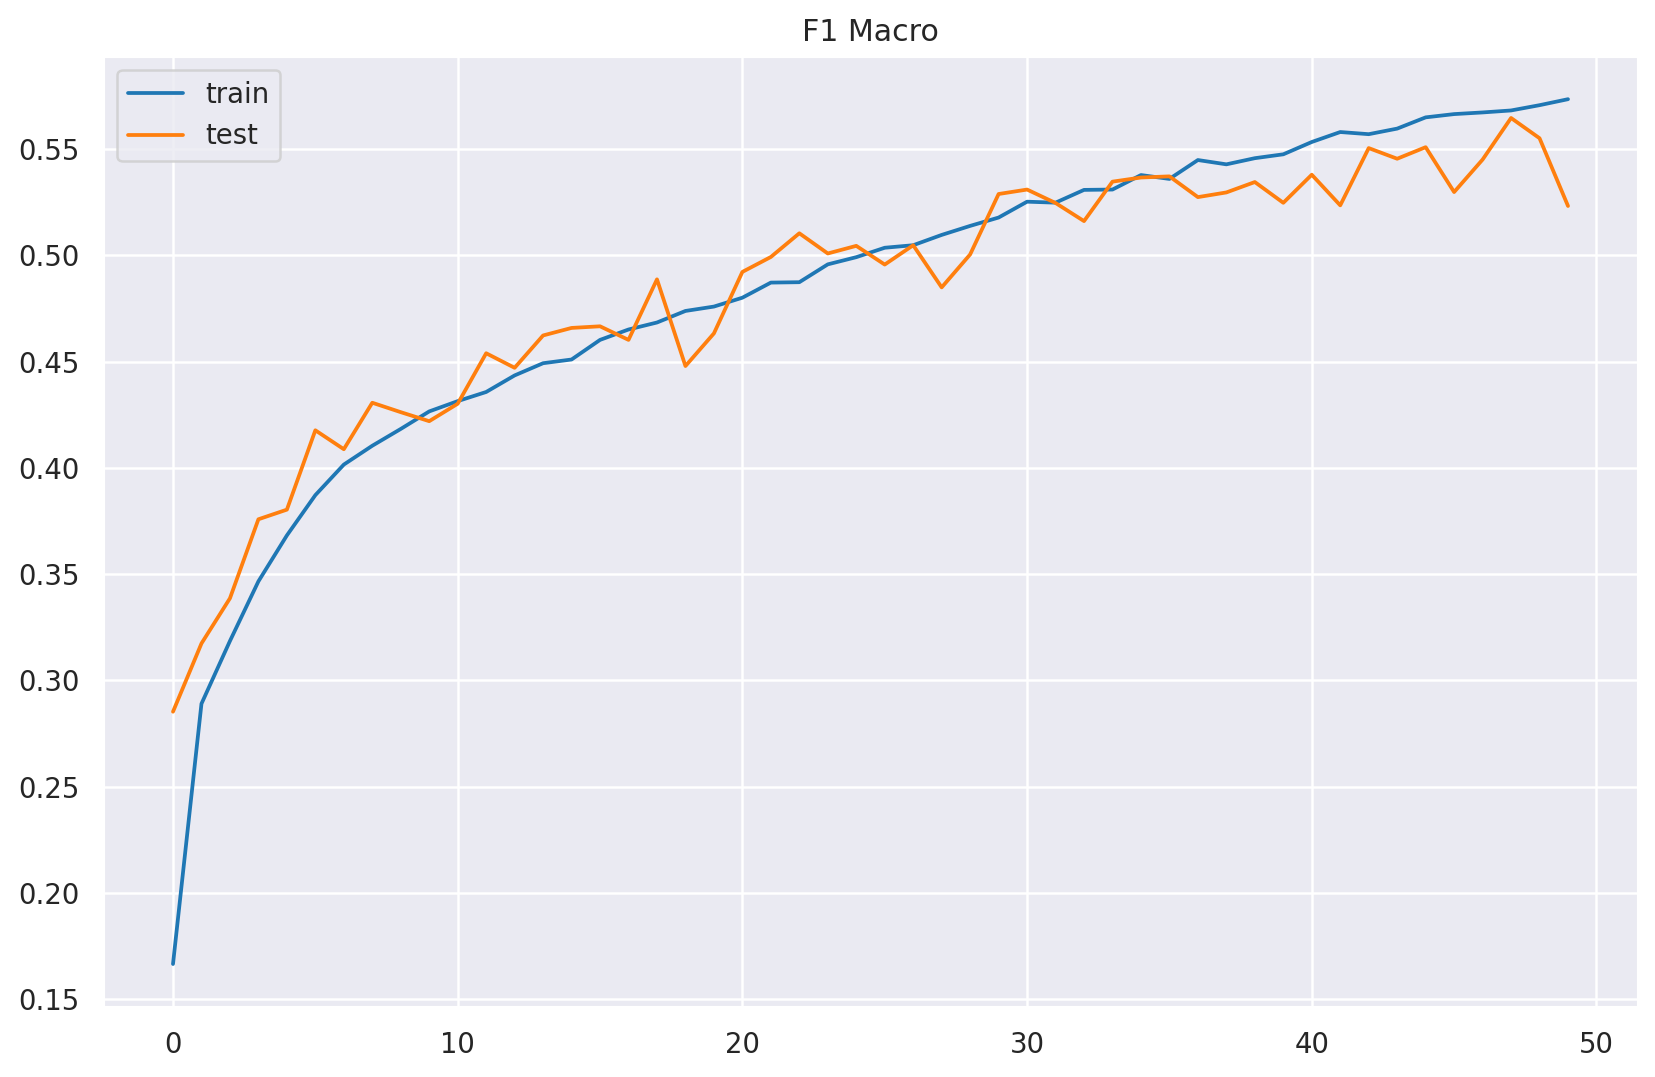

In [564]:
plt.title('F1 Macro')
plt.plot(history.history['f1_macro'], label='train')
plt.plot(history.history['val_f1_macro'], label='test')
plt.legend()
plt.show();

In [565]:
y_pred = model.predict(X_val_indices)
predicted_categories = np.argmax(y_pred, axis = 1)

In [566]:
true_categories = np.argmax(Y_val.to_numpy(), axis=1)

In [567]:
100*Y_train.sum()/Y_train.sum().sum()

-1    39.664091
 0    20.671819
 1    39.664091
dtype: float64

In [568]:
100*Y_val.sum()/Y_val.sum().sum()

-1    14.535883
 0     7.612376
 1    77.851740
dtype: float64

In [569]:
TARGET_NAMES = ['negative', 'neutral', 'positive']
print(metrics.classification_report(true_categories, predicted_categories, target_names=TARGET_NAMES))

              precision    recall  f1-score   support

    negative       0.41      0.85      0.56     13779
     neutral       0.23      0.30      0.26      7216
    positive       0.96      0.74      0.83     73798

    accuracy                           0.72     94793
   macro avg       0.53      0.63      0.55     94793
weighted avg       0.82      0.72      0.75     94793



In [496]:
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[f1_macro])

history = model.fit(X_train_indices, Y_train, batch_size=64, epochs=50,
                    validation_data=(X_val_indices, Y_val),
                    class_weight=class_weight
                   )

Train on 126390 samples, validate on 189586 samples
Epoch 1/50
126390/126390 [==============================] - 400s 3ms/sample - loss: 0.6545 - f1_macro: 0.2916 - val_loss: 0.6276 - val_f1_macro: 0.2914
Epoch 2/50
126390/126390 [==============================] - 395s 3ms/sample - loss: 0.6339 - f1_macro: 0.2917 - val_loss: 0.6065 - val_f1_macro: 0.2925
Epoch 3/50
126390/126390 [==============================] - 393s 3ms/sample - loss: 0.6171 - f1_macro: 0.2977 - val_loss: 0.5879 - val_f1_macro: 0.3318
Epoch 4/50
126390/126390 [==============================] - 364s 3ms/sample - loss: 0.5966 - f1_macro: 0.3157 - val_loss: 0.5581 - val_f1_macro: 0.3349
Epoch 5/50
126390/126390 [==============================] - 367s 3ms/sample - loss: 0.5795 - f1_macro: 0.3446 - val_loss: 0.5420 - val_f1_macro: 0.3579
Epoch 6/50
126390/126390 [==============================] - 382s 3ms/sample - loss: 0.5629 - f1_macro: 0.3687 - val_loss: 0.5228 - val_f1_macro: 0.4137
Epoch 7/50
126390/126390 [==========

In [497]:
ev = model.evaluate(X_val_indices,Y_val)
print('Val set\n  Loss: {:0.3f}\n  F1 Macro: {:0.3f}'.format(ev[0],ev[1]))

189586/189586 [==============================] - 153s 809us/sample - loss: 0.4183 - f1_macro: 0.4959
Val set
  Loss: 0.418
  F1 Macro: 0.496


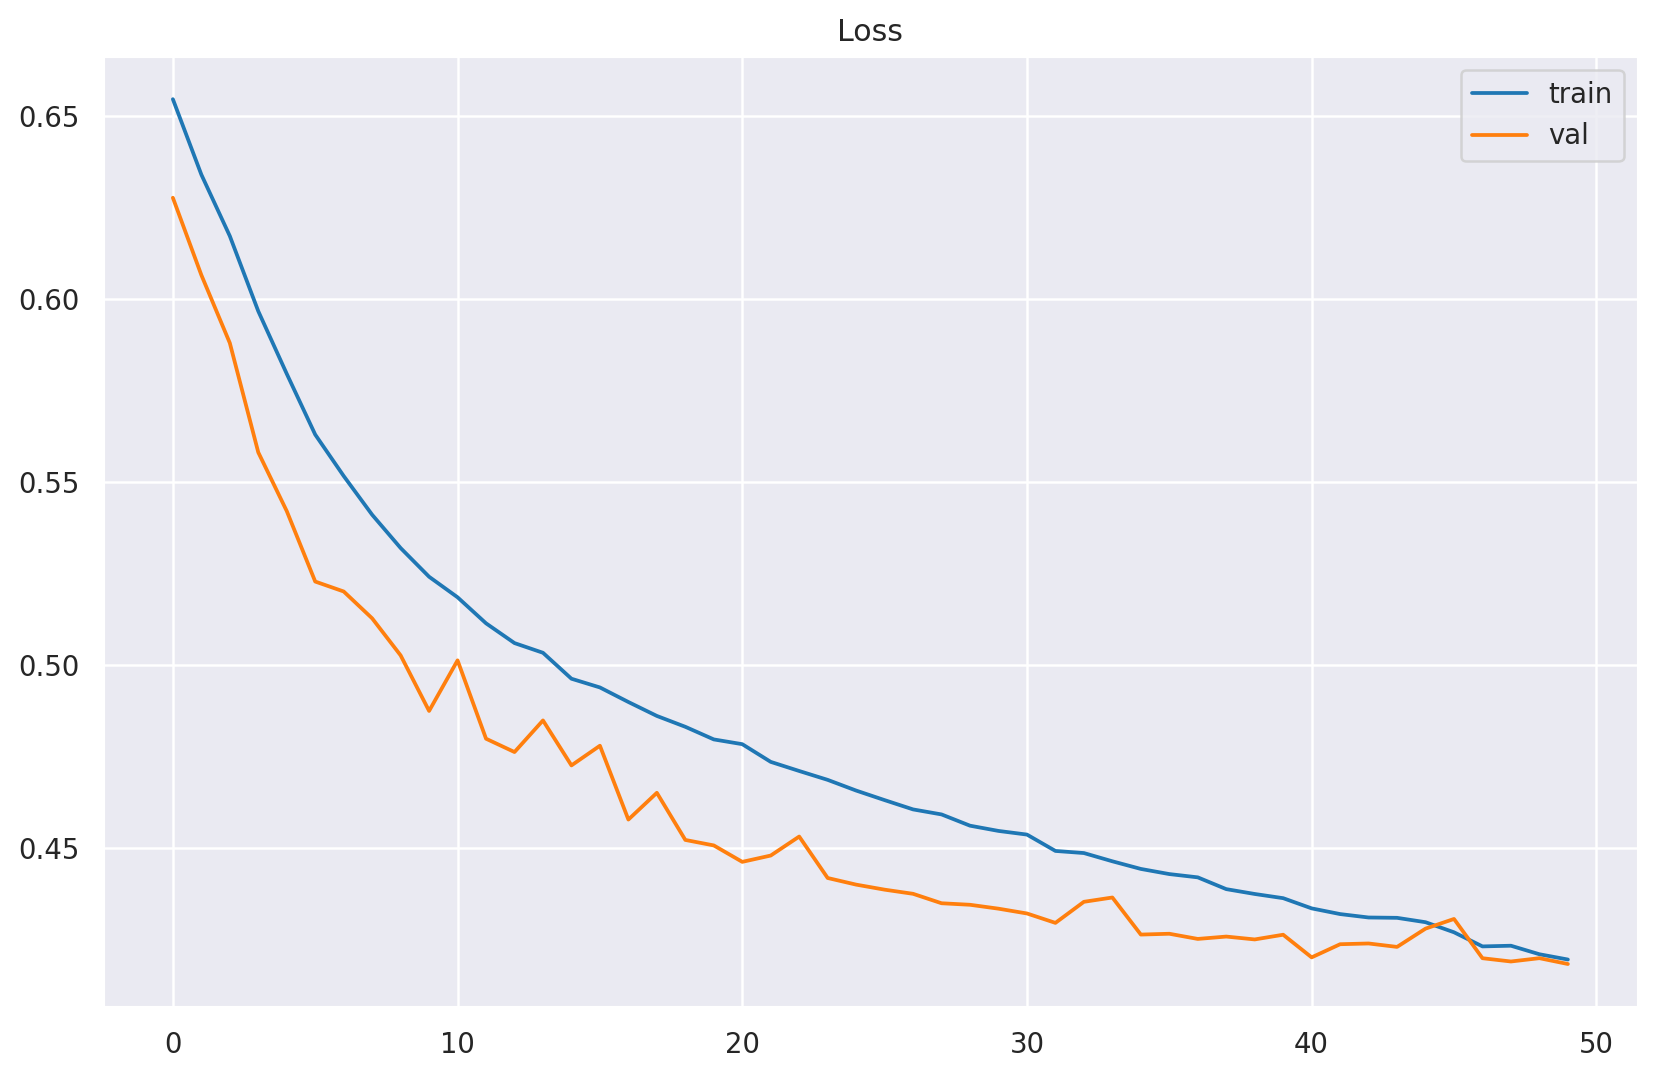

In [498]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

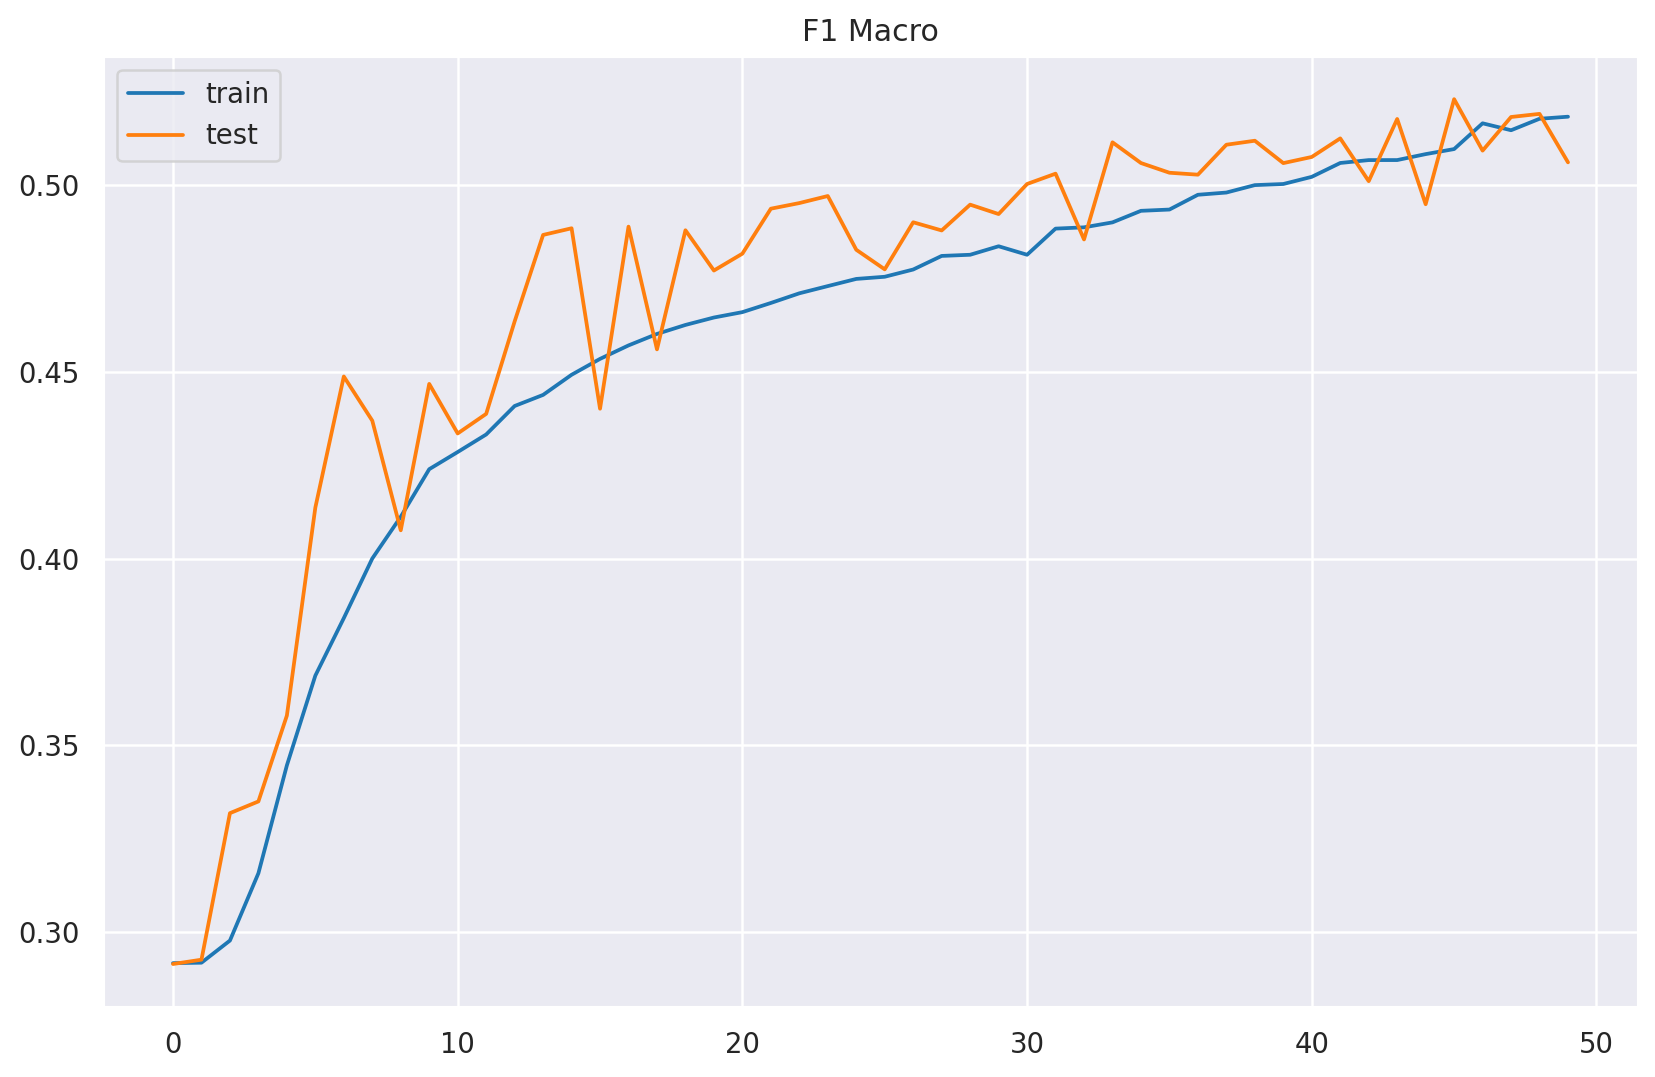

In [499]:
plt.title('F1 Macro')
plt.plot(history.history['f1_macro'], label='train')
plt.plot(history.history['val_f1_macro'], label='test')
plt.legend()
plt.show();

In [500]:
y_pred = model.predict(X_val_indices)
predicted_categories = np.argmax(y_pred, axis = 1)

In [501]:
true_categories = np.argmax(Y_val.to_numpy(), axis=1)

In [502]:
100*Y_train.sum()/Y_train.sum().sum()

-1    14.500356
 0     7.497429
 1    78.002215
dtype: float64

In [503]:
100*Y_val.sum()/Y_val.sum().sum()

-1    14.467313
 0     7.598135
 1    77.934552
dtype: float64

In [504]:
TARGET_NAMES = ['negative', 'neutral', 'positive']
print(metrics.classification_report(true_categories, predicted_categories, target_names=TARGET_NAMES))

              precision    recall  f1-score   support

    negative       0.72      0.56      0.63     27428
     neutral       0.42      0.06      0.11     14405
    positive       0.87      0.97      0.92    147753

    accuracy                           0.85    189586
   macro avg       0.67      0.53      0.55    189586
weighted avg       0.81      0.85      0.82    189586



In [507]:
model.save('my_second_model.h5')

In [162]:
model.get_weights()[0].shape

(5000, 100)

In [157]:
new_model = tensorflow.keras.models.load_model('my_first_model.h5', compile=False)

AttributeError: 'str' object has no attribute 'decode'

In [136]:
copy_history = history.history.copy()

In [137]:
copy_history

{'loss': [0.6840871810674667,
  0.6642211096048355,
  0.6606216537714005,
  0.6519012628793717,
  0.5799779237270355,
  0.5577402203798294,
  0.5659985074281693,
  0.5899840809345246,
  0.6019574404001236,
  0.6018555277824402,
  0.5998044787168503,
  0.5716858438968658,
  0.522342833662033,
  0.4914886512041092,
  0.47960545184612274,
  0.4442714869260788,
  0.429200494325161,
  0.4153901135206223,
  0.3988024941086769,
  0.3885852682828903,
  0.37877425668239595,
  0.3707779904127121,
  0.36378255401849746,
  0.35701874589920046,
  0.3504960661292076,
  0.34436385387182233,
  0.3390238626360893,
  0.33238737137913704,
  0.32792542357444765,
  0.32399381465911864,
  0.31912197328805925,
  0.3148887628018856,
  0.3104536224126816,
  0.3069948940038681,
  0.303467051666975,
  0.2999146607637405,
  0.29510585569143294,
  0.2911991319298744,
  0.28694512179493903,
  0.28462450805306433,
  0.2790725263774395,
  0.27227860821485517,
  0.26872722229361534,
  0.26403894102573394,
  0.25937067

In [ ]:
import json
with open('my_first_model_history.json', 'w') as json_file:
  json.dump(copy_history, json_file)

In [111]:
with open('my_first_model_history.json', 'r') as f:
  new_history = json.load(f)

In [112]:
new_history

"{'loss': [0.6840871810674667, 0.6642211096048355, 0.6606216537714005, 0.6519012628793717, 0.5799779237270355, 0.5577402203798294, 0.5659985074281693, 0.5899840809345246, 0.6019574404001236, 0.6018555277824402, 0.5998044787168503, 0.5716858438968658, 0.522342833662033, 0.4914886512041092, 0.47960545184612274, 0.4442714869260788, 0.429200494325161, 0.4153901135206223, 0.3988024941086769, 0.3885852682828903, 0.37877425668239595, 0.3707779904127121, 0.36378255401849746, 0.35701874589920046, 0.3504960661292076, 0.34436385387182233, 0.3390238626360893, 0.33238737137913704, 0.32792542357444765, 0.32399381465911864, 0.31912197328805925, 0.3148887628018856, 0.3104536224126816, 0.3069948940038681, 0.303467051666975, 0.2999146607637405, 0.29510585569143294, 0.2911991319298744, 0.28694512179493903, 0.28462450805306433, 0.2790725263774395, 0.27227860821485517, 0.26872722229361534, 0.26403894102573394, 0.2593706706523895, 0.2555642299711704, 0.25101759875416757, 0.24736973799467088, 0.2442984029263

- SUNBURST
- PCA  over each embedding space we use (eg. glove-wikipedia, glove-twitter, bert)
- We can visualize important/interesting words (the ones we found as interesting in the bigrams visualization or scattertext) and see its K clossest words in the embedding space.

In [ ]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

https://towardsdatascience.com/sentiment-analysis-using-lstm-and-glove-embeddings-99223a87fe8e

https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

---